In [1]:
from googleapiclient.discovery import build
import requests
import json
from pprint import pprint
import time
import pandas as pd
import glob
import pdb
import functools
import numpy as np
import itertools
import pyranges as pr
import pysam
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import storage
import pathlib
from matplotlib.backends.backend_pdf import PdfPages
from pandas.api.types import CategoricalDtype
from pandas.api.types import is_numeric_dtype
from pathlib import Path


In [2]:
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    '/home/gtd1521_jagmail_southalabama_edu/huvecs/development/google-cloud/alignments-65005-fdd2a449ed54.json')

#could use this for web app
#credentials = GoogleCredentials.get_application_default()


scoped_credentials = credentials.with_scopes(
    ['https://www.googleapis.com/auth/cloud-platform'])
#build the service from api
service = build('lifesciences', 'v2beta', credentials=scoped_credentials)

#storage client
storageClient = storage.Client(project="alignments-65005", credentials=credentials)

In [84]:
# genomicsBucket = storageClient.get_bucket("south-al-genomics")



In [51]:
#make mitochondrial bed
# NC_000845.1
mitoSize = 16569
starts = np.arange(0, mitoSize, 1)
stops = np.arange(1, mitoSize + 1, 1)
chrom = list(itertools.repeat("chrM", mitoSize))
names = ["Mito_" + str(i) for i in range(1, mitoSize + 1)]
score = list(itertools.repeat(0, mitoSize))

strand = list(itertools.repeat(".", mitoSize))

mitoDF = pd.DataFrame({"Chromosome": chrom, "Start": starts, 
              "End": stops, "Name": names, 
              "Score": score, "Strand": strand})
# for i in range(16613):
#     print(i, i+1)
pr.PyRanges(mitoDF).to_bed("mitochondria.allele.bed")

In [5]:
#add contig version to numt bed
def fixName(nameDF, inRow):
    fixedChrom = nameDF.loc[inRow['chrom'], "version"]
    inRow['chrom'] = fixedChrom
    return inRow

chromosomeDict = pd.read_csv('chromosome.versions.tsv', sep="\t", names=["short", "version"], index_col=0)
# chromosomeDict.loc['NW_018085356', "version"]

bedDF = pd.read_csv("numt-GRCh38.bed", sep="\t", names=["chrom", "start","end","name","score","strand"])
# for i, bedrow in bedDF.iterrows():

chromFix = functools.partial(fixName, chromosomeDict)
fixedDFChrom = bedDF.apply(chromFix, axis=1)
fixedDFChrom.to_csv("numt-GRCh38.fixed.bed", sep="\t", header=None, index=None)

In [4]:
# NUMT Stats
humanNUMTdf = pd.read_csv("numt-GRCh38.fixed.bed", sep="\t", index_col=None, 
                    names = ["Chromosome", "Start", "End", "Name", "Homology", "Strand"])
humanNUMTdf['Length'] = humanNUMTdf['End'] - humanNUMTdf['Start']

In [10]:
humanNUMTdf.loc[:,['Chromosome', 'Length']].groupby("Chromosome").agg(["count","sum"]).to_csv("workbooks/numt-stats.csv",sep=",")

## Coverage Calculations

In [4]:
def getDepthSample(inBed, bamName, sample, mapQual):
    inBed = pd.read_csv(inBed, sep="\t", names=["chr", "start", "end", "name", "score", "strand"])
    outDFList = []
    for bedCount, row in inBed.iterrows():
        chrom = row['chr']
        start = row['start']
        end = row['end']
        name = row['name']
        score = row['score']
        strand = row['strand']
        
        tempDepth = getDepth(chrom, start, end, bamName, mapQual)
        outDepthDFList = []
        for basePos, base in enumerate(tempDepth):
            outDepthDFList.append({"Chromosome": chrom, "Start": start, "End": end,
                       "Name": name, "Score": score, "Strand": strand,
                       "Sample": sample, "Offset": basePos, "Depth": base})
        outDFList.append(pd.DataFrame(outDepthDFList))
    outDF = pd.concat(outDFList, axis=0)
    return outDF

def readFilter(read, mapQual):
    pair = read.is_proper_pair
    qual = read.mapping_quality
    
    if( pair and (qual >= mapQual)):
        return True
    else:
        return False
        
def getDepth(chrom, start, end, bamName, mapQual):
    samfile = pysam.AlignmentFile(bamName, "rb")
    readCallbackDepth = functools.partial(readFilter, mapQual=mapQual)
    coverageList = samfile.count_coverage(chrom, start=start, stop=end, read_callback=readCallbackDepth)
    coverageList = [sum(base) for base in zip(*coverageList)]
    samfile.close()
    return coverageList

def driveBedCoverage(inBed, alignDir, design, mapQual=20):
#     typeRE = re.compile(r'([LP])')
#     sampleNumberRE = re.compile(r'[LP](\d+)')
#     timeRE = re.compile(r'_(\d+)')
    sampleDFList = []
    samples = pd.read_csv(design, sep="\t")
    bamList = list(alignDir.glob("*.bam"))
    for i, inBam in enumerate(bamList):
        fileName = inBam.name
        sample = fileName.split(".")[0]
#         sample = sampleRow["Sample"]
#         sampleDir = alignDir / sample

        sampleOutList = []

        print("*********************")
        print("Sample %s" % sample)
        tempSample = getDepthSample(inBed, inBam, sample, mapQual)
        sampleOutList.append(tempSample)
        concatForSample = pd.concat(sampleOutList, axis=0)
        #now aggregate the lane-level data into by-sample data
        #Could modify to keep flowcell info if desired
        
        aggForSample = concatForSample.groupby(['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand','Offset', 'Sample']).agg('sum')
        
        sampleDFList.append(aggForSample)
#         pdb.set_trace()
    allSamplesDF = pd.concat(sampleDFList, axis=0)
    return allSamplesDF.reset_index().set_index("Name")


In [4]:
from pathlib import Path
alignDir = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/new-alignments")
outDirCov = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/coverages")
if not outDirCov.is_dir():
    outDirCov.mkdir()

In [66]:
humanNumtRaw = driveBedCoverage("numt-GRCh38.fixed.bed", alignDir,"design.csv")
humanNumtRaw.to_csv(outDirCov / "Human-Numt-Coverage-Raw.tsv", sep="\t")


*********************
Sample SL266689
*********************
Sample MGUSA_19
*********************
Sample SL266687
*********************
Sample MGUSA_6
*********************
Sample MGUSA_20
*********************
Sample MGUSA_7
*********************
Sample MGUSA_5
*********************
Sample MGUSA_8
*********************
Sample SL266690
*********************
Sample SL266688
*********************
Sample MGUSA_18


In [67]:
humanNumtShufRaw = driveBedCoverage("shuf-numt.bed", alignDir,"design.csv")
humanNumtShufRaw.to_csv(outDirCov / "Shuffle-Numt-Coverage-Raw.tsv", sep="\t")

*********************
Sample SL266689
*********************
Sample MGUSA_19
*********************
Sample SL266687
*********************
Sample MGUSA_6
*********************
Sample MGUSA_20
*********************
Sample MGUSA_7
*********************
Sample MGUSA_5
*********************
Sample MGUSA_8
*********************
Sample SL266690
*********************
Sample SL266688
*********************
Sample MGUSA_18


In [68]:
diyamaSitesRaw = driveBedCoverage("Dayama-supplemental/bedtools-slop/dayama.grch38.200slop.bed", alignDir,"design.csv")
diyamaSitesRaw.to_csv(outDirCov / "Diyama-Site-Coverage-Raw.tsv", sep="\t")

*********************
Sample SL266689
*********************
Sample MGUSA_19
*********************
Sample SL266687
*********************
Sample MGUSA_6
*********************
Sample MGUSA_20
*********************
Sample MGUSA_7
*********************
Sample MGUSA_5
*********************
Sample MGUSA_8
*********************
Sample SL266690
*********************
Sample SL266688
*********************
Sample MGUSA_18


In [69]:
humanMtRaw = driveBedCoverage("mito.full.human.bed", alignDir,"design.csv")
humanMtRaw.to_csv(outDirCov / "Human-Mito-Coverage-Raw.tsv", sep="\t")


*********************
Sample SL266689
*********************
Sample MGUSA_19
*********************
Sample SL266687
*********************
Sample MGUSA_6
*********************
Sample MGUSA_20
*********************
Sample MGUSA_7
*********************
Sample MGUSA_5
*********************
Sample MGUSA_8
*********************
Sample SL266690
*********************
Sample SL266688
*********************
Sample MGUSA_18


In [3]:
from pathlib import Path
alignDirMitoOnly = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/mito-only-align/")
outDirCov = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/coverages")
if not outDirCov.is_dir():
    outDirCov.mkdir()
    
humanMtOnlyAlignRaw = driveBedCoverage("mito.full.human.bed", alignDirMitoOnly,"design.csv")
humanMtOnlyAlignRaw.to_csv(outDirCov / "Human-MitoOnlyAlign-Coverage-Raw.tsv", sep="\t")

*********************
Sample MGUSA_19-Mito-Only
*********************
Sample SL266689-Mito-Only
*********************
Sample MGUSA_6-Mito-Only
*********************
Sample MGUSA_8-Mito-Only
*********************
Sample MGUSA_7-Mito-Only
*********************
Sample SL266688-Mito-Only
*********************
Sample SL266687-Mito-Only
*********************
Sample SL266690-Mito-Only
*********************
Sample MGUSA_5-Mito-Only
*********************
Sample MGUSA_20-Mito-Only
*********************
Sample MGUSA_18-Mito-Only


,Chromosome,Start,End,Score,Strand,Offset,Sample,Depth
Name,,,,,,,,
Human_Mitochondria,chrM,0,16569,100,.,0,SL266689,359
Human_Mitochondria,chrM,0,16569,100,.,1,SL266689,364
Human_Mitochondria,chrM,0,16569,100,.,2,SL266689,381
Human_Mitochondria,chrM,0,16569,100,.,3,SL266689,382
Human_Mitochondria,chrM,0,16569,100,.,4,SL266689,390
...,...,...,...,...,...,...,...,...
Human_Mitochondria,chrM,0,16569,100,.,16564,MGUSA_18,0
Human_Mitochondria,chrM,0,16569,100,.,16565,MGUSA_18,0
Human_Mitochondria,chrM,0,16569,100,.,16566,MGUSA_18,0


NameError: name 'humanMtNorm' is not defined

In [2]:
def getInsertsSample(inBed, bamName, sample):
    inBed = pd.read_csv(inBed, sep="\t", names=["chr", "start", "end", "name", "score", "strand"])
    outDFList = []
    for bedCount, row in inBed.iterrows():
        chrom = row['chr']
        start = row['start']
        end = row['end']        
        insertDF = pd.DataFrame(getInsertsByRegion(chrom, start, end, bamName, maxInsert=1000))
        insertDF['Sample'] = sample
#         outInsertDFList = []
#         for index, insertCount in insertArray.iteritems():
#             outInsertDFList.append({"Sample": sample})
        outDFList.append(insertDF)
    outDF = pd.concat(outDFList, axis=0)
    return outDF

        
def getInsertsByRegion(chrom, start, end, bamName, maxInsert=1000):
    rawList = []
    samfile = pysam.AlignmentFile(bamName, "rb")
    for read in samfile.fetch(chrom, start, end):
        pair = read.is_proper_pair
        qual = read.mapping_quality

#         insertSize = min(read.template_length, maxInsert)
        insertSize = abs(read.template_length)
        # have been observing an issue where many are not properly paired and it's listed that the insert size is 0. Seems to be a NUMT issue
        if(insertSize <= maxInsert):
            rawList.append(insertSize)
    samfile.close()
    return pd.Series(rawList, name="Fragments")

def driveBedInsert(inBed, alignDir, designFile, outDir):

    sampleStatList = []
    sampleHistList = []
    samples = pd.read_csv(designFile, sep="\t")
    bamList = list(alignDir.glob("*.bam"))
    for i, inBam in enumerate(bamList):
        fileName = inBam.name
        sample = fileName.split(".")[0]
        print("Sample " + sample)
        tempSample = getInsertsSample(inBed, inBam, sample)
        tempSample.to_csv(outDir / (sample + ".tsv"))
        tempStats = tempSample['Fragments'].describe()
#         pdb.set_trace()
        tempStats['Sample'] = sample
        sampleStatList.append(tempStats)
        
        #histograms
        intervalLength = 1000
        sampleDens, sampleIntervals = np.histogram(tempSample['Fragments'],bins=np.arange(1,intervalLength + 2,1), density=True)
        sampleDens = pd.Series(sampleDens, name="Raw Density")
        sampleIntervals = pd.Series(sampleIntervals[:intervalLength], name="Intervals")
        sampleHist = pd.concat([sampleDens, sampleIntervals], axis=1)
        sampleHist['Sample'] = sample
        sampleHist['% Density'] = sampleHist['Raw Density'] * 100
        sampleHistList.append(sampleHist)
    allHist = pd.concat(sampleHistList, axis=0)
    allStatsDF = pd.DataFrame(sampleStatList).reset_index(drop=True)
    return allStatsDF, allHist



In [95]:
from pathlib import Path
alignDir = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/new-alignments")
outDirInsert = Path("inserts/")
if not outDirInsert.is_dir():
    outDirInsert.mkdir()

outDirMito = Path(outDirInsert / "mito")
if not outDirMito.is_dir():
    outDirMito.mkdir()
    
outDirNumt = Path(outDirInsert / "numt")
if not outDirNumt.is_dir():
    outDirNumt.mkdir()


In [96]:

numtInsertStats, numtInsertHist = driveBedInsert("numt-GRCh38.fixed.bed", alignDir,"design.csv", outDirNumt)
numtInsertStats.to_csv(outDirInsert / "Numt-Insert-Stats.tsv", sep="\t", index=False)
numtInsertHist.to_csv(outDirInsert / "Numt-Insert-Hist.tsv", sep="\t", index=False)

# del pigInsertNumt

Sample SL266689


/home/gtd1521_jagmail_southalabama_edu/mitochondrial/novogene-9-9-20/Processing_Sept_2020/envs/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Sample MGUSA_19
Sample SL266687
Sample MGUSA_6
Sample MGUSA_20
Sample MGUSA_7
Sample MGUSA_5
Sample MGUSA_8
Sample SL266690
Sample SL266688
Sample MGUSA_18


In [82]:
# pigInsertNumtShuf = driveBedInsert("pig-numts.shuffled.bed", "design.csv", alignDir)
# pigInsertNumtShuf.to_csv(outDirInsert / "Pig-Shuffle-Numt-Inserts-Raw.tsv", sep="\t")
# del pigInsertNumtShuf

In [97]:
alignDir = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/new-alignments")
outDirInsert = Path("inserts/")
if not outDirInsert.is_dir():
    outDirInsert.mkdir()
mitoInsertStats, mitoInsertHist = driveBedInsert("mito.full.human.bed", alignDir, "design.csv", outDirMito)
mitoInsertStats.to_csv(outDirInsert / "Mito-Insert-Stats.tsv", sep="\t", index=False)
mitoInsertHist.to_csv(outDirInsert / "Mito-Insert-Hist.tsv", sep="\t", index=False)
# del pigInsertMito

Sample SL266689
Sample MGUSA_19
Sample SL266687
Sample MGUSA_6
Sample MGUSA_20
Sample MGUSA_7
Sample MGUSA_5
Sample MGUSA_8
Sample SL266690
Sample SL266688
Sample MGUSA_18


## combined stats

### Insert Stats

In [42]:
designDF

,Sample,Enrichment,Condition,Day,Location,Patient,Age,Race,Lactate,Creatinine,Patient Code
0,SL266687,Enriched,Normal,1,Mobile,1,41,African-American,6.4,1.12,No Transfusion 1
1,SL266688,Enriched,Normal,3,Mobile,1,41,African-American,4.6,0.86,No Transfusion 1
2,SL266689,Enriched,Massive Transfusion,1,Mobile,2,33,White,5.9,1.08,Massive Transfusion 1
3,SL266690,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12,Massive Transfusion 1
4,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10,No Transfusion 2
5,MGUSA_6,Enriched,Normal,3,Tallahassee,3,41,African-American,3.3,0.92,No Transfusion 2
6,MGUSA_7,Enriched,Massive Transfusion,1,Tallahassee,4,38,White,2.9,1.04,Massive Transfusion 2
7,MGUSA_8,Enriched,Massive Transfusion,3,Tallahassee,4,38,White,2.4,1.17,Massive Transfusion 2
8,MGUSA_18,Nonenriched,Normal,3,Tallahassee,3,41,African-American,3.3,0.92,No Transfusion 2
9,MGUSA_19,Nonenriched,Massive Transfusion,1,Tallahassee,4,38,White,2.9,1.04,Massive Transfusion 2


In [3]:
outDirInsert = Path("inserts")

outDirPlot = Path("plots")
if not outDirPlot.is_dir():
    print("make directory")
    outDirPlot.mkdir()

designDF = pd.read_csv("design.csv", sep="\t")
cat_type_time = CategoricalDtype(categories=["1", "3"],
         ordered=True)
designDF['Day'] = designDF['Day'].astype(str).astype(cat_type_time)

cat_type_code = CategoricalDtype(categories=["No Transfusion 1", "No Transfusion 2", "Massive Transfusion 1",
                                            "Massive Transfusion 2"],
         ordered=True)
designDF['Patient Code'] = designDF['Patient Code'].astype(cat_type_code)
# mitoInsertsCutdown = pd.read_csv(outDirInsert / "Mito-Inserts-Raw.tsv", sep="\t")
# numtInsertsCutdown = pd.read_csv(outDirInsert / "Numt-Inserts-Raw.tsv", sep="\t")

# mitoInsertsCutdown = mitoInsertsCutdown.merge(designDF, on="Sample", how="left")
outDirInsert = Path("inserts/")
numtInsertStats = pd.read_csv(outDirInsert / "Numt-Insert-Stats.tsv", sep="\t")
numtInsertHist = pd.read_csv(outDirInsert / "Numt-Insert-Hist.tsv", sep="\t")
mitoInsertStats= pd.read_csv(outDirInsert / "Mito-Insert-Stats.tsv", sep="\t")
mitoInsertHist= pd.read_csv(outDirInsert / "Mito-Insert-Hist.tsv", sep="\t")

numtInsertStats["Insert Origin"] = "NUMT"
numtInsertHist["Insert Origin"] = "NUMT"
mitoInsertStats["Insert Origin"] = "Mito"
mitoInsertHist["Insert Origin"] = "Mito"

insertStatsAll = pd.concat([numtInsertStats, mitoInsertStats], axis=0)
insertHistAll = pd.concat([numtInsertHist, mitoInsertHist], axis=0)

insertStatsAll = insertStatsAll.merge(designDF, on="Sample", how="left")
insertHistAll = insertHistAll.merge(designDF, on="Sample", how="left")

CategoricalDtype(categories=['No Transfusion 1', 'No Transfusion 2',
                  'Massive Transfusion 1', 'Massive Transfusion 2'],
                 ordered=True)

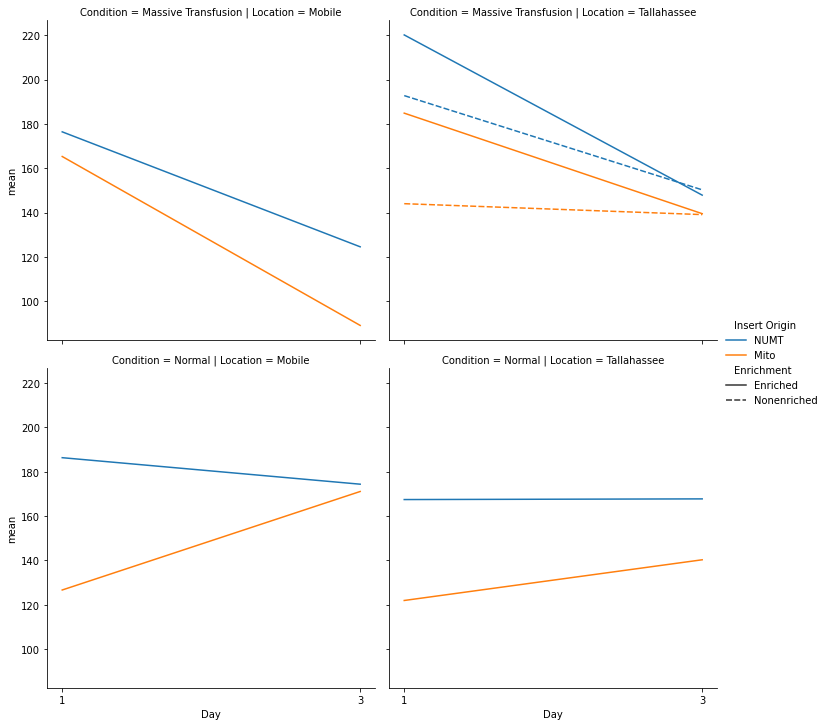

In [4]:
g = sns.relplot(x="Day", y="mean", hue="Insert Origin", units="Patient",
            row="Condition", col="Location", style="Enrichment",
            data=insertStatsAll, kind="line", estimator=None)
plt.show()
g.savefig("plots/insert-stats.svg")
g.savefig("plots/insert-stats.png")

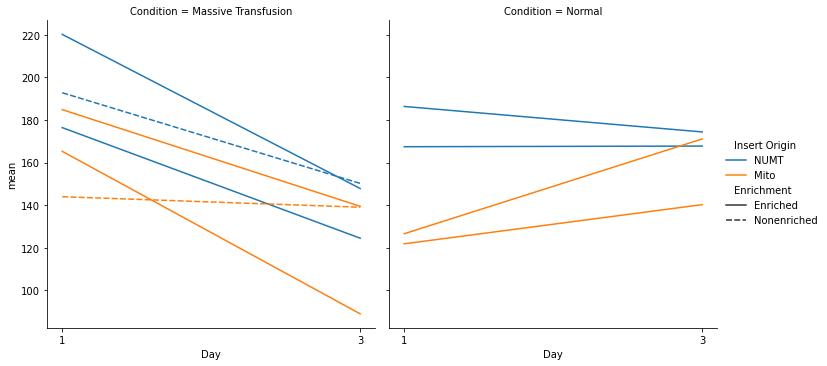

In [6]:
g = sns.relplot(x="Day", y="mean", hue="Insert Origin", units="Patient",
            col="Condition", style="Enrichment",
            data=insertStatsAll, kind="line", estimator=None)
plt.show()
g.savefig("plots/insert-collapsed-stats.svg")
g.savefig("plots/insert-collapsed-stats.png")

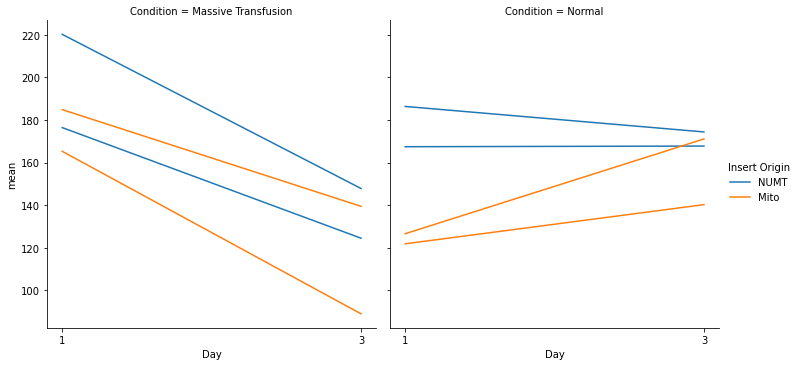

In [101]:
g = sns.relplot(x="Day", y="mean", hue="Insert Origin", units="Patient",
            col="Condition",data=insertStatsAll.query('Enrichment == "Enriched"'), 
                kind="line", estimator=None)
plt.show()
g.savefig("plots/insert-collapsed-stats.svg")
g.savefig("plots/insert-collapsed-stats.png")

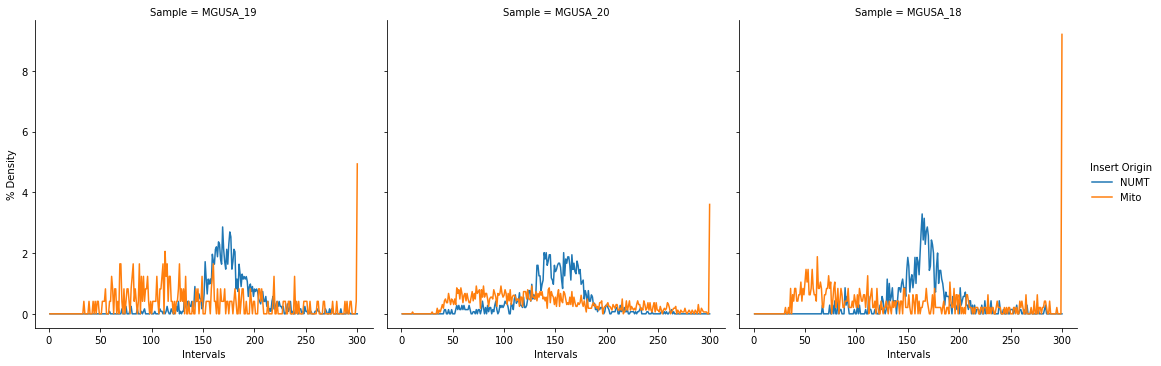

In [42]:
g = sns.relplot(x="Intervals", y='% Density', hue="Insert Origin", units="Patient",
            col="Sample", col_wrap=3,
            data=insertHistAll.query('Enrichment == "Nonenriched"'), kind="line", estimator=None)
plt.show()
g.savefig("plots/insert-distributions-nonenriched.svg")
g.savefig("plots/insert-distributions-nonenriched.png")

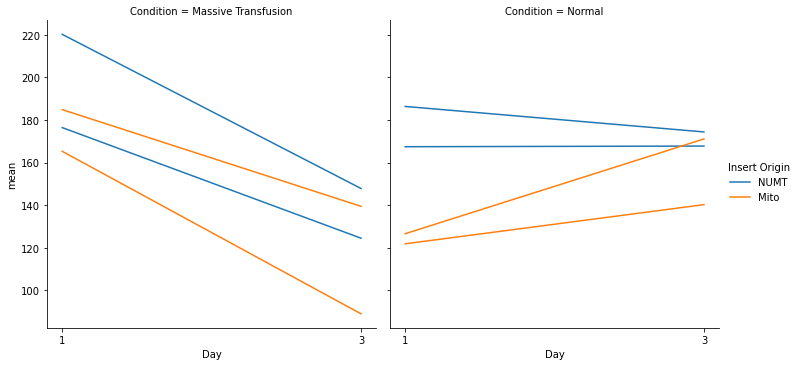

In [102]:
formattedInserts = insertStatsAll.query('Enrichment == "Enriched"')

g = sns.relplot(x="Day", y="mean", hue="Insert Origin", units="Patient",
            col="Condition",data=insertStatsAll.query('Enrichment == "Enriched"'), 
                kind="line", estimator=None)
plt.show()

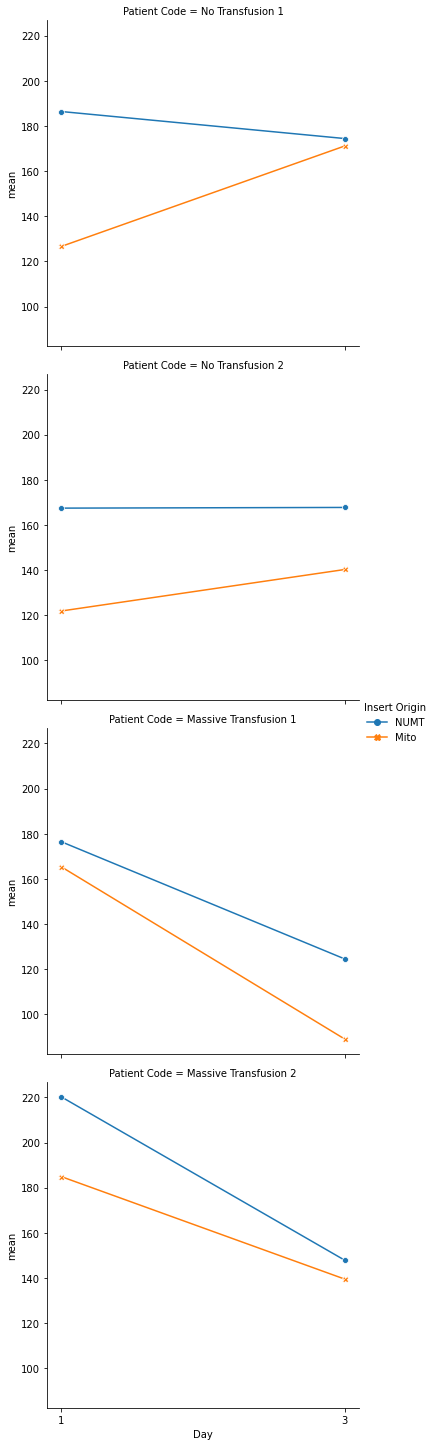

In [7]:
g = sns.relplot(x="Day", y="mean", hue="Insert Origin",style="Insert Origin", units="Patient",
            row="Patient Code",  markers=True, dashes=False,
            data=insertStatsAll.query('Enrichment == "Enriched"'),
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"]
                , kind="line", estimator=None)
g.savefig("plots/insert-stats-format.svg")
g.savefig("plots/insert-stats-format.png")
plt.show()

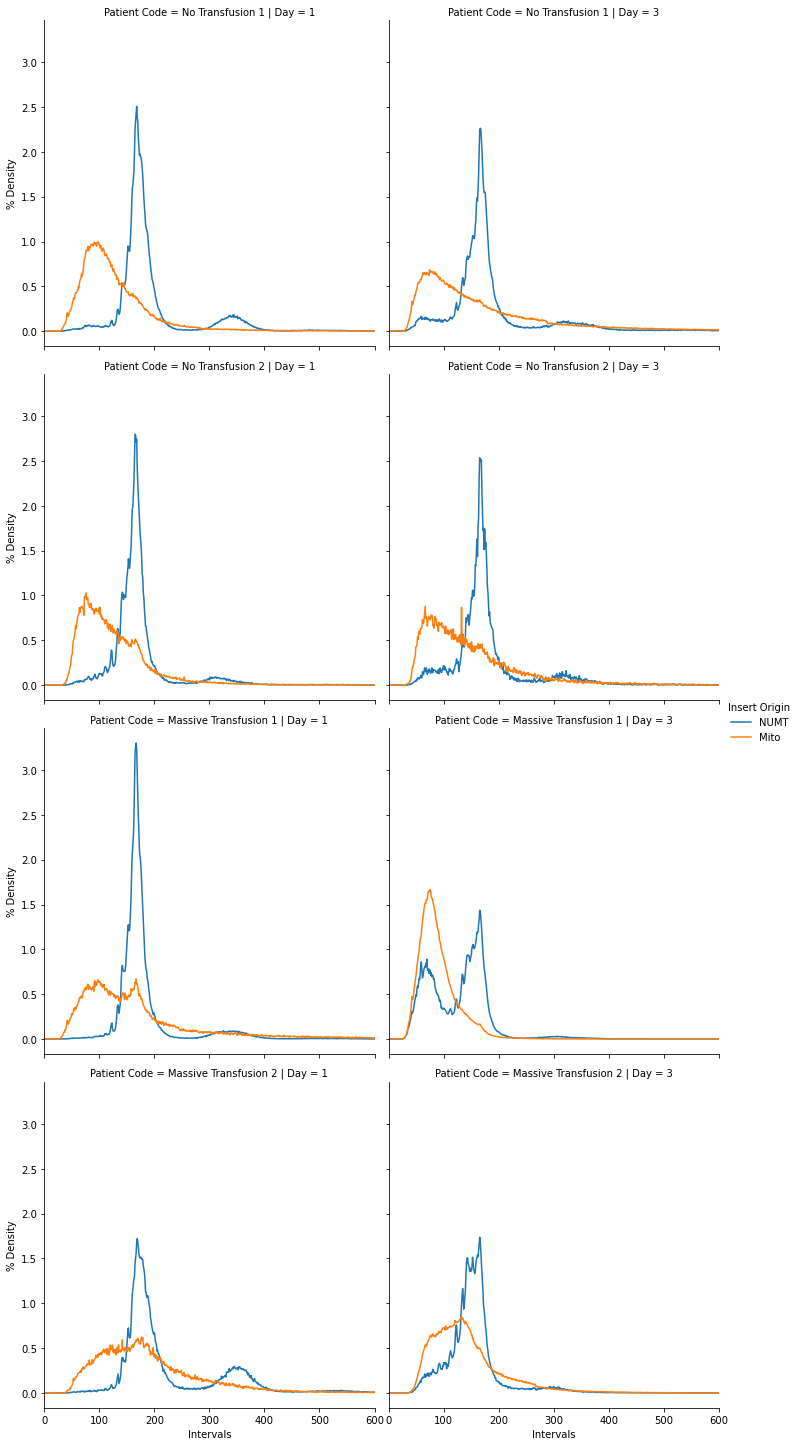

In [28]:
g = sns.relplot(x="Intervals", y='% Density', hue="Insert Origin", units="Patient",
            row="Patient Code", col="Day",
            data=insertHistAll.query('Enrichment == "Enriched"'), 
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"], kind="line", estimator=None)

# with np.nditer(g.axes, op_flags=['readwrite']) as it:
#     for ax in it:
#         ax.set_xlim(0, 600)
[i.set_xlim(0,600) for i in g.axes_dict.values()]
plt.show()
g.savefig("plots/insert-distributions-enriched.svg")
g.savefig("plots/insert-distributions-enriched.png")

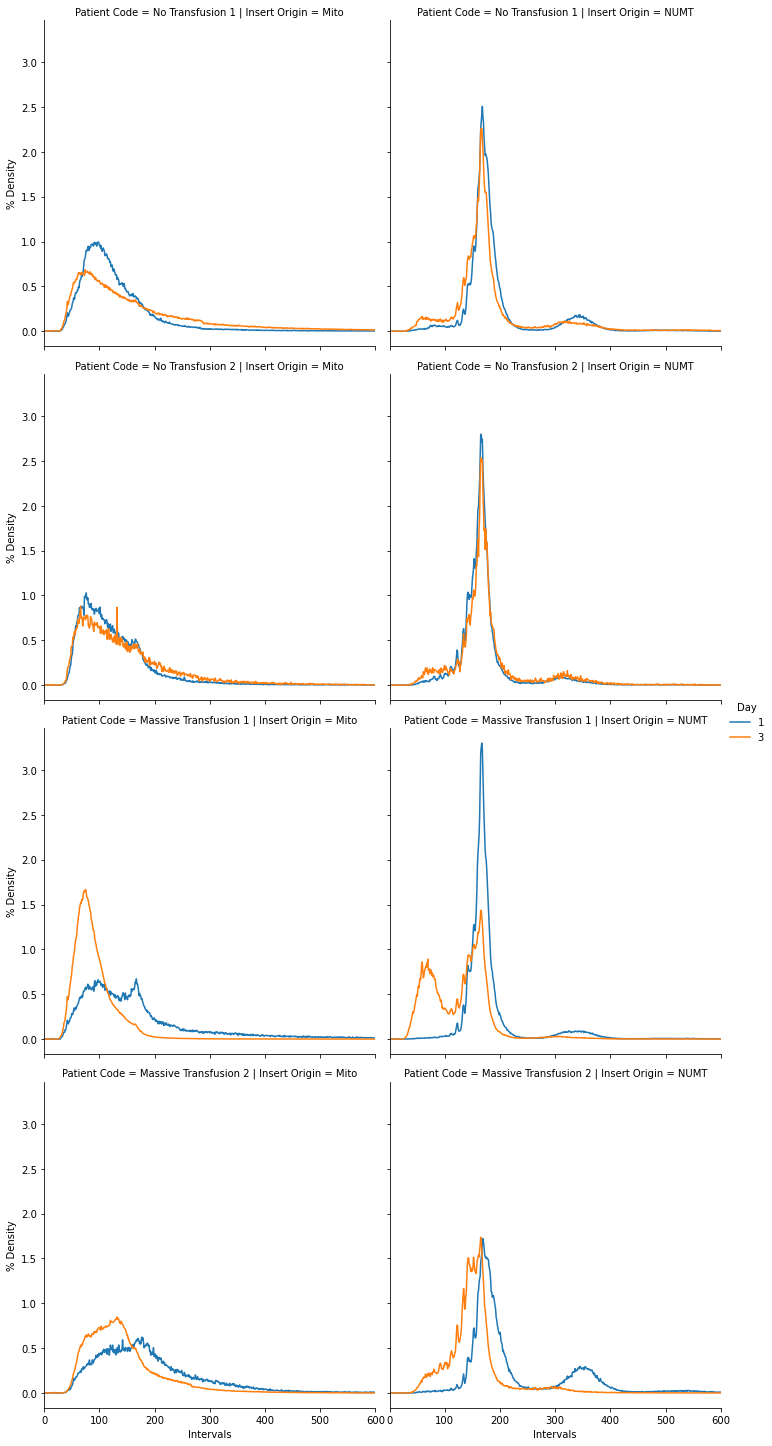

In [30]:
g = sns.relplot(x="Intervals", y='% Density', hue="Day", units="Patient",
            row="Patient Code", col="Insert Origin",
            data=insertHistAll.query('Enrichment == "Enriched"'), 
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"], kind="line",
                col_order=["Mito", "NUMT"], estimator=None)

# with np.nditer(g.axes, op_flags=['readwrite']) as it:
#     for ax in it:
#         ax.set_xlim(0, 600)
[i.set_xlim(0,600) for i in g.axes_dict.values()]
plt.show()

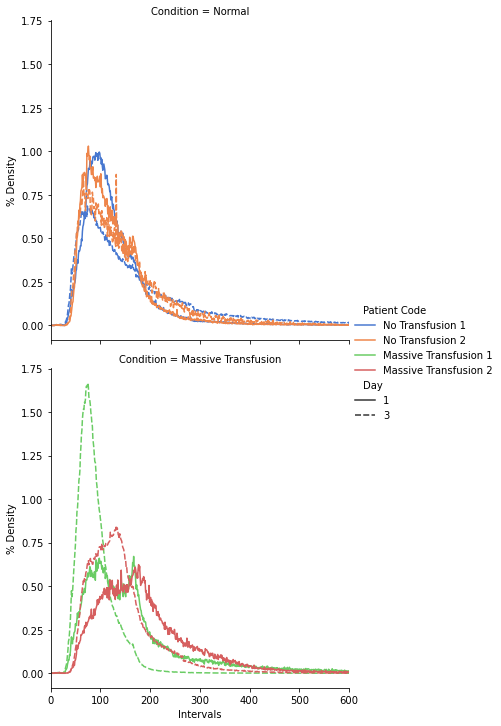

In [45]:
g = sns.relplot(x="Intervals", y='% Density', hue="Patient Code", style="Day",
            row="Condition", palette="muted",
            data=insertHistAll.query('(Enrichment == "Enriched") and (`Insert Origin` == "Mito")'), 
                row_order=["Normal", "Massive Transfusion"], kind="line", ci=None)

# with np.nditer(g.axes, op_flags=['readwrite']) as it:
#     for ax in it:
#         ax.set_xlim(0, 600)
[i.set_xlim(0,600) for i in g.axes_dict.values()]
plt.show()
g.savefig("plots/insert-distributions-mito-only.svg")
g.savefig("plots/insert-distributions-mito-only.png")

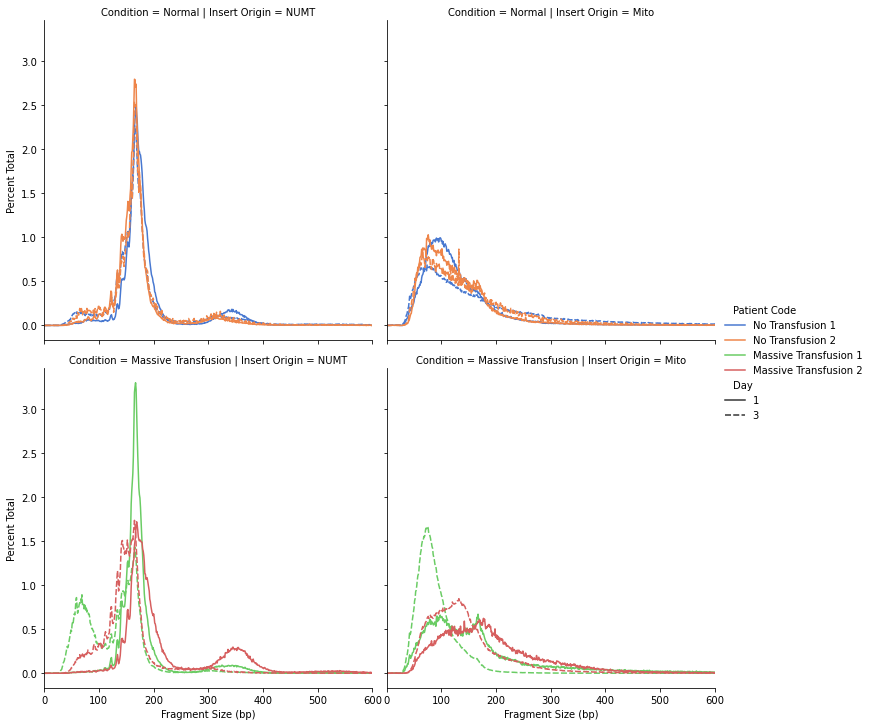

In [37]:
g = sns.relplot(x="Intervals", y='% Density', hue="Patient Code", style="Day",
            row="Condition", col="Insert Origin", palette="muted",
            data=insertHistAll.query('(Enrichment == "Enriched")'), 
                row_order=["Normal", "Massive Transfusion"], kind="line", ci=None)

# with np.nditer(g.axes, op_flags=['readwrite']) as it:
#     for ax in it:
#         ax.set_xlim(0, 600)
[i.set_xlim(0,600) for i in g.axes_dict.values()]
[i.set_xlabel("Fragment Size (bp)") for i in g.axes_dict.values()]
[i.set_ylabel("Percent Total") for i in g.axes_dict.values()]

plt.show()
g.savefig("plots/insert-distributions-mito-numt.svg")
g.savefig("plots/insert-distributions-mito-numt.png")

In [32]:
insertHistAll['Condition'].value_counts()

Massive Transfusion    12000
Normal                 10000
Name: Condition, dtype: int64

In [ ]:
# add x li
g = sns.relplot(x="Intervals", y='% Density', hue="Insert Origin", units="Patient",
            row="Patient Code", col="Day",
            data=insertHistAll.query('Enrichment == "Enriched"'), 
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"], kind="line", estimator=None)
plt.show()

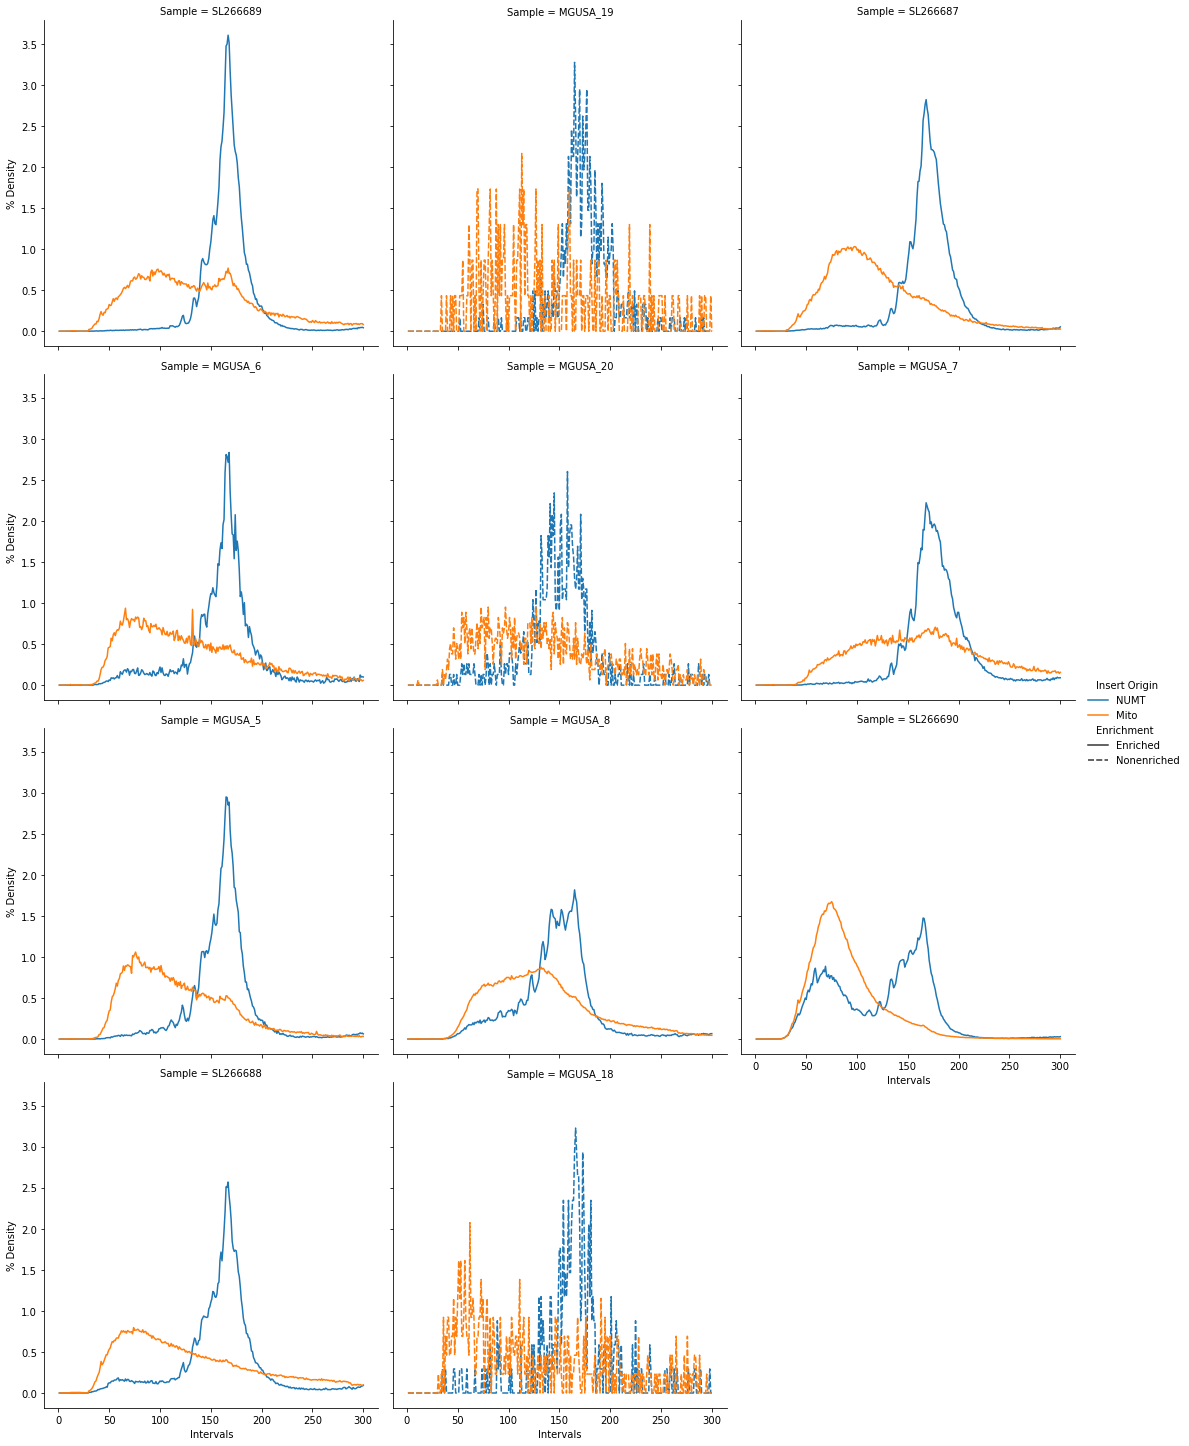

In [73]:
g = sns.relplot(x="Intervals", y='% Density', hue="Insert Origin", units="Patient",
            col="Sample", col_wrap=3, style="Enrichment",
            data=insertHistAll, kind="line", estimator=None)
plt.show()
g.savefig("plots/insert-distributions.svg")
g.savefig("plots/insert-distributions.png")

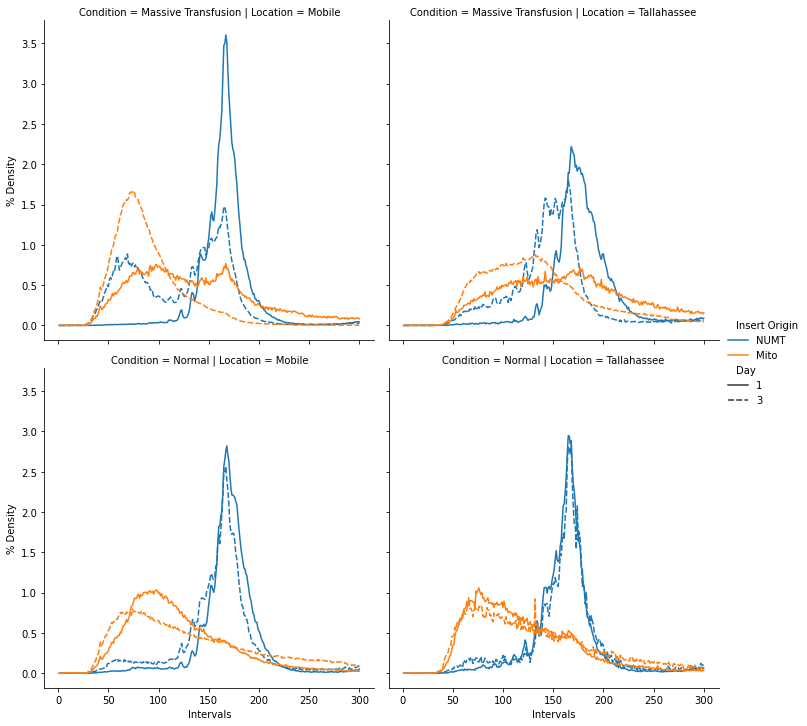

In [74]:
sns.relplot(x="Intervals", y='% Density', hue="Insert Origin", units="Patient",
             style="Day", row="Condition", col="Location",
            data=insertHistAll.query('Enrichment == "Enriched"'), kind="line", estimator=None)
plt.show()

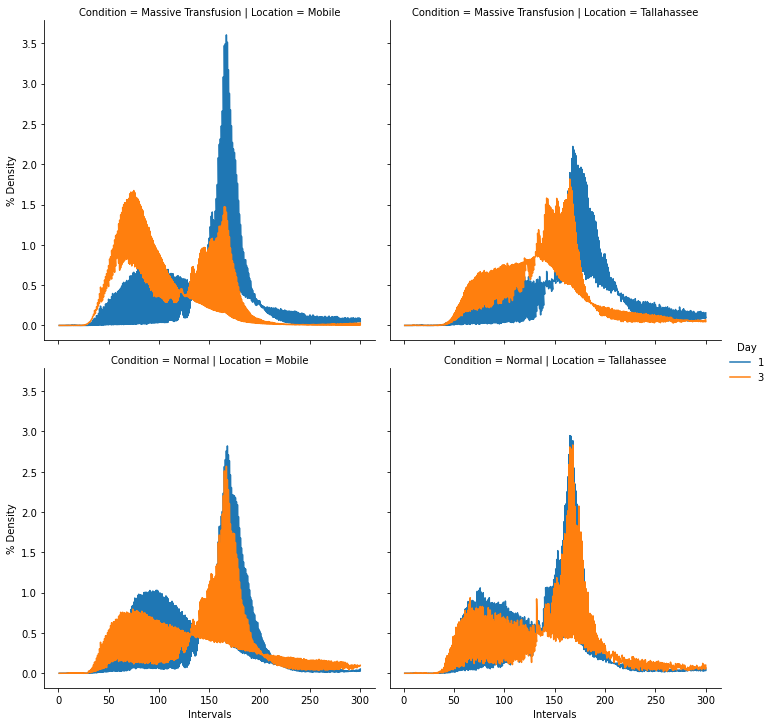

In [75]:
sns.relplot(x="Intervals", y='% Density', hue="Day", units="Patient",
            row="Condition", col="Location",
            data=insertHistAll.query('Enrichment == "Enriched"'), kind="line", estimator=None)
plt.show()

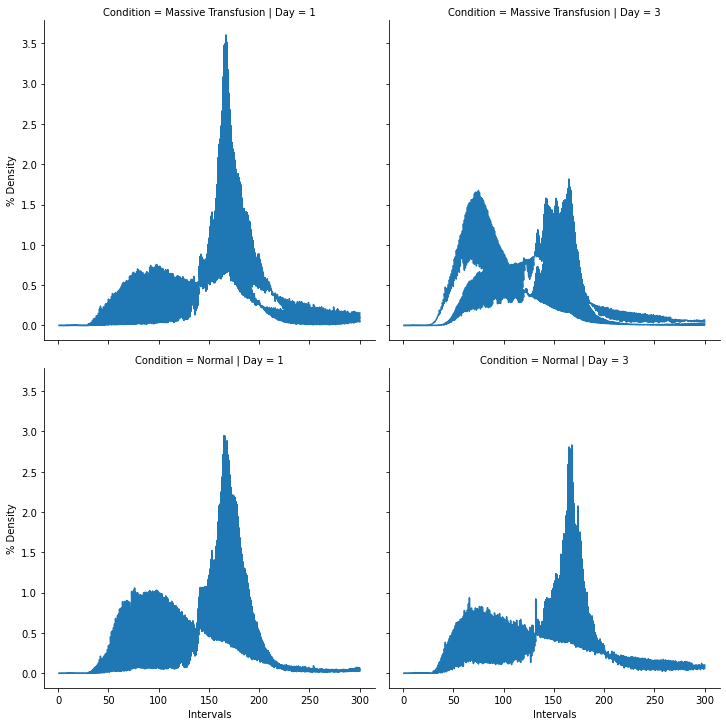

In [76]:
sns.relplot(x="Intervals", y='% Density', col="Day", units="Patient",
            row="Condition",
            data=insertHistAll.query('Enrichment == "Enriched"'), kind="line", estimator=None)
plt.show()

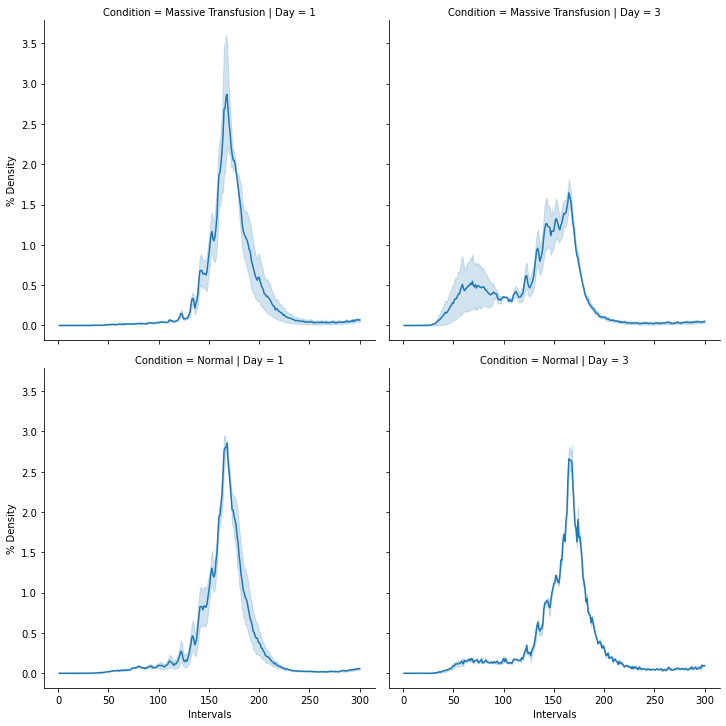

In [77]:
g = sns.relplot(x="Intervals", y='% Density', col="Day",
            row="Condition",
            data=insertHistAll.query('(Enrichment == "Enriched") and (`Insert Origin` == "NUMT")'), kind="line")
plt.show()
g.savefig("plots/mito-inserts-byDay-numt.svg")
g.savefig("plots/mito-inserts-byDay-numt.png")

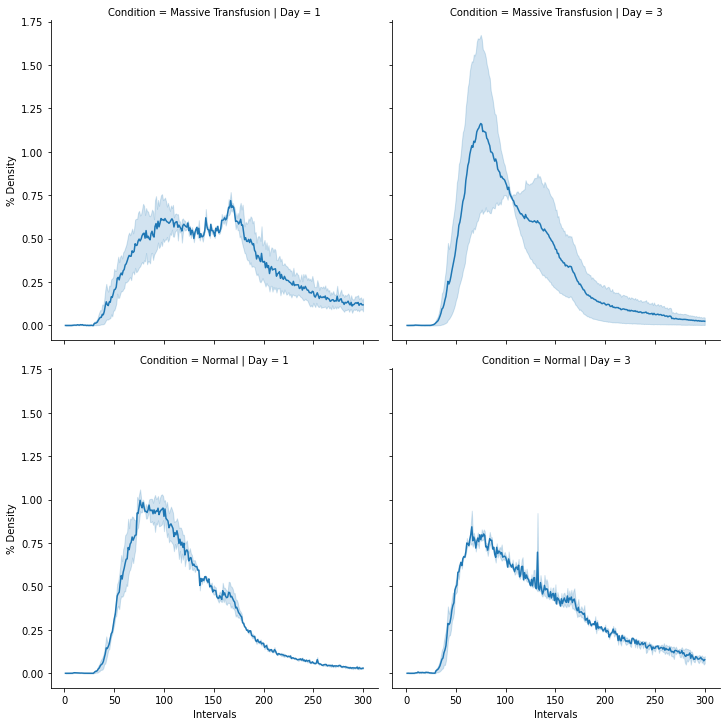

In [78]:
g = sns.relplot(x="Intervals", y='% Density', col="Day",
            row="Condition",
            data=insertHistAll.query('(Enrichment == "Enriched") and (`Insert Origin` == "Mito")'), kind="line")
plt.show()
g.savefig("plots/mito-inserts-byDay-mito.svg")
g.savefig("plots/mito-inserts-byDay-mito.png")

### Coverages

In [8]:
mitoAlignOnlyCov

,Name,Chromosome,Start,End,Score,Strand,Offset,Sample,Depth
0,Human_Mitochondria,chrM,0,16569,100,.,0,SL266689,359
1,Human_Mitochondria,chrM,0,16569,100,.,1,SL266689,364
2,Human_Mitochondria,chrM,0,16569,100,.,2,SL266689,381
3,Human_Mitochondria,chrM,0,16569,100,.,3,SL266689,382
4,Human_Mitochondria,chrM,0,16569,100,.,4,SL266689,390
...,...,...,...,...,...,...,...,...,...
182254,Human_Mitochondria,chrM,0,16569,100,.,16564,MGUSA_18,0
182255,Human_Mitochondria,chrM,0,16569,100,.,16565,MGUSA_18,0
182256,Human_Mitochondria,chrM,0,16569,100,.,16566,MGUSA_18,0
182257,Human_Mitochondria,chrM,0,16569,100,.,16567,MGUSA_18,0


In [8]:
from pathlib import Path
coverageDir = Path("coverages")

designDF = pd.read_csv("design.csv", sep="\t")
cat_type_time = CategoricalDtype(categories=["1", "3"],
         ordered=True)
designDF['Day'] = designDF['Day'].astype(cat_type_time)

mitoCovCutdown = pd.read_csv(coverageDir / "Human-Mito-Coverage-Raw.tsv", sep="\t")
numtCovCutdown = pd.read_csv(coverageDir / "Human-Numt-Coverage-Raw.tsv", sep="\t")
shufNumtCovCutdown = pd.read_csv(coverageDir / "Shuffle-Numt-Coverage-Raw.tsv", sep="\t")
diyamaCovCutdown = pd.read_csv(coverageDir / "Diyama-Site-Coverage-Raw.tsv", sep="\t")
# these are the coverages aligned only to the mitochondria
mitoAlignOnlyCov = pd.read_csv(coverageDir / "Human-MitoOnlyAlign-Coverage-Raw.tsv", sep="\t")

#aggregate by numt
covByNumt = numtCovCutdown.groupby(["Name", "Chromosome", "Start", "End", "Strand","Score","Sample"])["Depth"].agg('sum').reset_index()
covByNumt['Length'] = covByNumt['End'] - covByNumt['Start']
covByNumt['Mean'] = covByNumt['Depth'] / covByNumt['Length']

#aggregate by shuffle
covByShuf = shufNumtCovCutdown.groupby(["Name", "Chromosome", "Start", "End", "Strand","Score","Sample"])["Depth"].agg('sum').reset_index()
covByShuf['Length'] = covByShuf['End'] - covByShuf['Start']
covByShuf['Mean'] = covByShuf['Depth'] / covByShuf['Length']

#aggregate by Diyama
covByDiyama = diyamaCovCutdown.groupby(["Name", "Chromosome", "Start", "End", "Strand","Score","Sample"])["Depth"].agg('sum').reset_index()
covByDiyama['Length'] = covByDiyama['End'] - covByDiyama['Start']
covByDiyama['Mean'] = covByDiyama['Depth'] / covByDiyama['Length']


# normalize each site in mito by dividing by mean NUMT coverage
numtStats = numtCovCutdown.loc[:, ["Sample", "Depth"]].groupby("Sample").describe()
numtMeans = numtCovCutdown.loc[:, ["Sample", "Depth"]].groupby("Sample").agg('mean')

# Normalize by mean numt coverages

humanMtNorm = mitoCovCutdown.merge(numtMeans, how="left", on="Sample", suffixes=["_Mito", "_NUMT"])
humanMtNorm["Norm Depth"] = humanMtNorm["Depth_Mito"] / humanMtNorm["Depth_NUMT"]

mitoAlignOnlyCov['Sample'] = mitoAlignOnlyCov['Sample'].str.replace("-Mito-Only", "")
mitoAlignOnlyNorm = mitoAlignOnlyCov.merge(numtMeans, how="left", on="Sample", suffixes=["_Mito", "_NUMT"])
mitoAlignOnlyNorm['Norm Depth'] = mitoAlignOnlyNorm["Depth_Mito"] / mitoAlignOnlyNorm["Depth_NUMT"]


covByNumt = covByNumt.merge(numtMeans.rename(columns={"Depth": "Mean All NUMT"})
                    , how="left", on="Sample")
covByNumt['Normalized Mean'] = covByNumt['Mean'] / covByNumt['Mean All NUMT']

covByShuf = covByShuf.merge(numtMeans.rename(columns={"Depth": "Mean All NUMT"})
                    , how="left", on="Sample")
covByShuf['Normalized Mean'] = covByShuf['Mean'] / covByShuf['Mean All NUMT']

covByDiyama = covByDiyama.merge(numtMeans.rename(columns={"Depth": "Mean All NUMT"})
                    , how="left", on="Sample")
covByDiyama['Normalized Mean'] = covByDiyama['Mean'] / covByDiyama['Mean All NUMT']

In [9]:
from pathlib import Path
# alignDir = Path("/mnt/disks/scratch/alignments-pig/alignments")
def mitoBigwigs():
    rawDir = Path("/home/gtd1521_jagmail_southalabama_edu/mitochondrial/mitoPseudo4_24_19/newPseudogenome/workflow-11-2020/coverages")

    outDir = Path("coverages-mito")
    if not outDir.is_dir():
        outDir.mkdir()
    humanMtRaw = pd.read_csv(rawDir / "Human-Mito-Coverage-Raw.tsv", sep="\t")
    humanNUMTRaw = pd.read_csv(rawDir / "Human-Numt-Coverage-Raw.tsv", sep="\t")



    # filenameList = []
    for name, group in humanMtNorm.groupby("Sample"):
        outGroup = group.copy().reset_index(drop=True)
        outGroup['Start'] = outGroup['Offset']
        outGroup['End']  = outGroup['Start'] + 1
        outGroupNorm = outGroup.copy()
        outGroup['Count'] = outGroup['Depth_Mito']
        outGroupNorm['Count'] = outGroup['Norm Depth']

        outNameRaw = name + "-raw"
        outNameNorm = name + "-norm"

    #     filenameList.append(outName)

        outGroup = outGroup.loc[:, ["Chromosome", "Start", "End", "Count"]]
        outGroup.to_csv(outDir / (outNameRaw + ".bg"), sep="\t", index=False, header=False)

        outGroupNorm = outGroupNorm.loc[:, ["Chromosome", "Start", "End", "Count"]]
        outGroupNorm.to_csv(outDir / (outNameNorm + ".bg"), sep="\t", index=False, header=False)

    #     tempPyRanges = pr.PyRanges(outGroup)
    #     tempPyRanges.to_bigwig(path = str(outDir / (outNameRaw + ".bw")))

    #     tempPyRangesNorm = pr.PyRanges(outGroupNorm)
    #     tempPyRangesNorm.to_bigwig(path = str(outDir / (outNameNorm + ".bw")))
mitoBigwigs()
# print(*filenameList, sep=" ")

In [10]:
# percent error of mito only align
def mitoOnlyBigwigs():
    coverageDir = Path("coverages")
    outDir = Path("mito-only-align/bigwigs")

    mitoCovRaw = pd.read_csv(coverageDir / "Human-Mito-Coverage-Raw.tsv", sep="\t")
    mtOnlyRaw = pd.read_csv(coverageDir / "Human-MitoOnlyAlign-Coverage-Raw.tsv", sep="\t")
    mtOnlyRaw['Sample'] = mtOnlyRaw['Sample'].replace(to_replace="-Mito-Only", value="",regex=True)
    mergedMitoRaw = mitoCovRaw.merge(mtOnlyRaw, on=["Name", "Chromosome", "Start", "End", "Strand","Score","Offset","Sample"],
                                    suffixes=["_WGalign", "_MitoOnly"])
    mergedMitoRaw['Percent Error'] = (((mergedMitoRaw['Depth_MitoOnly'] - mergedMitoRaw['Depth_WGalign'] + 0.00001)) / (mergedMitoRaw['Depth_WGalign'] + 0.00001)) * 100
#     mergedMitoRaw['Percent Error'] = mergedMitoRaw['Depth_MitoOnly'] - mergedMitoRaw['Depth_WGalign']

    mergedMitoRaw.to_csv(coverageDir / "percentError.csv")
    for name, group in mergedMitoRaw.groupby("Sample"):
        outGroup = group.copy().reset_index(drop=True)
        outGroup['Start'] = outGroup['Offset']
        outGroup['End']  = outGroup['Start'] + 1
        outGroup['Count'] = outGroup['Depth_MitoOnly']

        outGroupError = group.copy().reset_index(drop=True)
        outGroupError['Start'] = outGroupError['Offset']
        outGroupError['End']  = outGroupError['Start'] + 1
    #     pdb.set_trace()
        outNameRaw = name + "-raw"
        outNameError = name + "-percent-error"

    #     filenameList.append(outName)

        outGroup = outGroup.loc[:, ["Chromosome", "Start", "End", "Count"]]
        outGroup.to_csv(outDir / (outNameRaw + ".bg"), sep="\t", index=False, header=False)

        outGroupError = outGroupError.loc[:, ["Chromosome", "Start", "End", "Percent Error"]]
        outGroupError.to_csv(outDir / (outNameError + ".bg"), sep="\t", index=False, header=False)

    #     tempPyRanges = pr.PyRanges(outGroup)
    #     tempPyRanges.to_bigwig(path = str(outDir / (outNameRaw + ".bw")))
    return mergedMitoRaw
    
mergedMitoRaw = mitoOnlyBigwigs()


In [11]:
designDF = pd.read_csv("design.csv", sep="\t")
mergedMitoCopy = mergedMitoRaw.copy().merge(designDF,on="Sample")



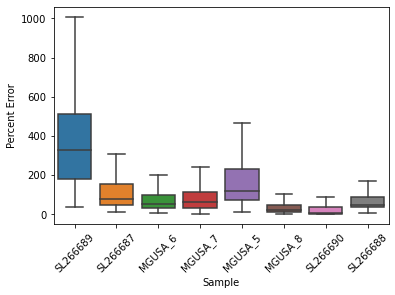

In [8]:
sns.boxplot(x="Sample",y="Percent Error", data=mergedMitoCopy.query('(Enrichment == "Enriched") and( (Offset < 3105) or(Offset > 3107))'), showfliers=False)
plt.xticks(rotation = 45)
plt.show()

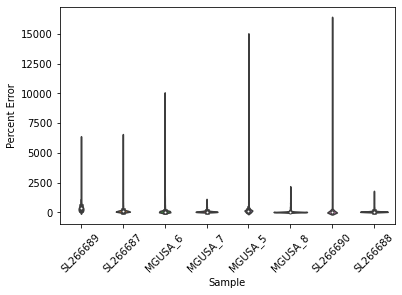

In [18]:
sns.violinplot(x="Sample",y="Percent Error", data=mergedMitoCopy.query('(Enrichment == "Enriched") and( (Offset < 3105) or(Offset > 3107))'), showfliers=False)
plt.xticks(rotation = 45)
plt.show()

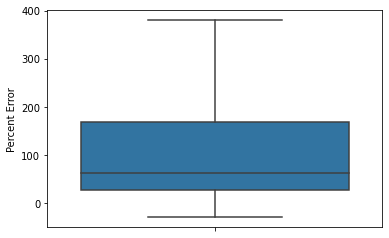

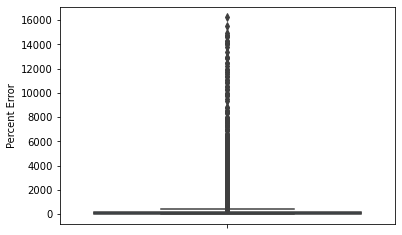

In [9]:
sns.boxplot(y="Percent Error", data=mergedMitoCopy.query('Enrichment == "Enriched"'), showfliers=False)
plt.xticks(rotation = 45)
plt.show()

sns.boxplot(y="Percent Error", data=mergedMitoCopy.query('Enrichment == "Enriched"'), showfliers=True)
plt.xticks(rotation = 45)
plt.show()

In [12]:
humanMtNormBins = humanMtNorm.reset_index().copy()
humanMtNormBins['Bin'] = (humanMtNormBins['Offset'] // 100 ) + 1
binnedMeans = pd.pivot_table(humanMtNormBins, values=["Depth_Mito", "Norm Depth"], index=["Bin"], columns="Sample", aggfunc="mean")

In [13]:
# meanCovDF = aggregateCovStats(humanMtNorm)
mitoStats = humanMtNorm.groupby('Sample')['Depth_Mito', 'Norm Depth', 'Depth_NUMT'].describe()
mitoStatsFlat = mitoStats.copy()
mitoStatsFlat.columns = mitoStatsFlat.columns.map('_'.join)

# mitoNormStats = humanMtNorm.groupby('Sample')['Norm Depth'].describe()
mitoStatsFlat['Depth_Mito_cv'] = mitoStatsFlat['Depth_Mito_mean'] / mitoStatsFlat['Depth_Mito_std']
mitoStatsFlat['Norm Depth_cv'] = mitoStatsFlat['Norm Depth_mean'] / mitoStatsFlat['Norm Depth_std']
mitoStatsFlat['Depth_NUMT_cv'] = mitoStatsFlat['Depth_NUMT_mean'] / mitoStatsFlat['Depth_NUMT_std']

meanCovMerged = mitoStatsFlat.merge(designDF, how="left", on="Sample")


/home/gtd1521_jagmail_southalabama_edu/mitochondrial/novogene-9-9-20/Processing_Sept_2020/envs/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [14]:
# mito Only stats
#mitoAlignOnlyNorm

mitoOnlyStats = mitoAlignOnlyNorm.groupby('Sample')['Depth_Mito', 'Norm Depth', 'Depth_NUMT'].describe()
mitoOnlyStatsFlat = mitoOnlyStats.copy()
mitoOnlyStatsFlat.columns = mitoOnlyStatsFlat.columns.map('_'.join)

# mitoNormStats = humanMtNorm.groupby('Sample')['Norm Depth'].describe()
mitoOnlyStatsFlat['Depth_Mito_cv'] = mitoOnlyStatsFlat['Depth_Mito_mean'] / mitoOnlyStatsFlat['Depth_Mito_std']
mitoOnlyStatsFlat['Norm Depth_cv'] = mitoOnlyStatsFlat['Norm Depth_mean'] / mitoOnlyStatsFlat['Norm Depth_std']
mitoOnlyStatsFlat['Depth_NUMT_cv'] = mitoOnlyStatsFlat['Depth_NUMT_mean'] / mitoOnlyStatsFlat['Depth_NUMT_std']

meanMitoOnlyCovMerged = mitoOnlyStatsFlat.merge(designDF, how="left", on="Sample")


/home/gtd1521_jagmail_southalabama_edu/mitochondrial/novogene-9-9-20/Processing_Sept_2020/envs/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


### Write Raw/Minimally Processed Data to Workbook

In [15]:
outDirWorkbooks = Path("workbooks")
if not outDirWorkbooks.is_dir():
    print("make directory")
    outDirWorkbooks.mkdir()

import datetime
now = datetime.datetime.now()
writer = pd.ExcelWriter(outDirWorkbooks / ('DAMP-Data-trali-'+ str(now) + '.xlsx'), engine='xlsxwriter')
insertStatsAll.to_excel(writer, "Insert Stats",index=False)


insertHistPivot = insertHistAll.pivot(index=["Intervals"], columns=["Sample","Insert Origin"], values=["% Density"])
insertHistPivot.to_excel(writer, "Insert Distributions")

meanCovMerged.to_excel(writer, "Coverage Stats",index=False)
meanMitoOnlyCovMerged.to_excel(writer, "Mito Only Coverage Stats", index=False)

#binned mito coverage
binnedMeans.to_excel(writer, "100bp Binned Coverage")

#pivot mito coverage
covPivot = humanMtNorm.pivot(index=["Chromosome", "Start", "End", "Name", "Score", "Strand", "Offset"],
                 columns="Sample", values=["Depth_Mito", "Depth_NUMT", "Norm Depth"]).reset_index()
covPivot.to_excel(writer, "Mito Coverage")

# alignments to mito only
covPivotMitoOnly = mitoAlignOnlyNorm.pivot(index=["Chromosome", "Start", "End", "Name", "Score", "Strand", "Offset"],
                 columns="Sample", values=["Depth_Mito", "Depth_NUMT", "Norm Depth"]).reset_index()
covPivotMitoOnly.to_excel(writer, "Mito-Only Aligned Coverage")


#pivot numt
covNumtPivot = covByNumt.pivot(index=["Chromosome", "Start", "End", "Name", "Score", "Strand", "Length"],
                 columns="Sample", values=["Depth","Length", "Mean","Mean All NUMT","Normalized Mean"]).reset_index()
covNumtPivot.to_excel(writer, "Numt Mean Coverage")


covShufPivot = covByShuf.pivot(index=["Chromosome", "Start", "End", "Name", "Score", "Strand", "Length"],
                 columns="Sample", values=["Depth","Length", "Mean","Mean All NUMT","Normalized Mean"]).reset_index()
covShufPivot.to_excel(writer, "Shuf Mean Coverage")

covDiyamaPivot = covByDiyama.pivot(index=["Chromosome", "Start", "End", "Name", "Score", "Strand", "Length"],
                 columns="Sample", values=["Depth","Length", "Mean","Mean All NUMT","Normalized Mean"]).reset_index()
covDiyamaPivot.to_excel(writer, "Dayama Mean Coverage")

writer.save()
 

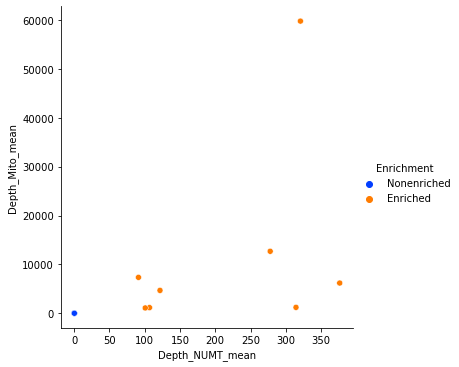

In [46]:
rawCovPlot = sns.relplot(x="Depth_NUMT_mean", y="Depth_Mito_mean", hue="Enrichment",
            data=meanCovMerged, kind="scatter", estimator=None, palette="bright")

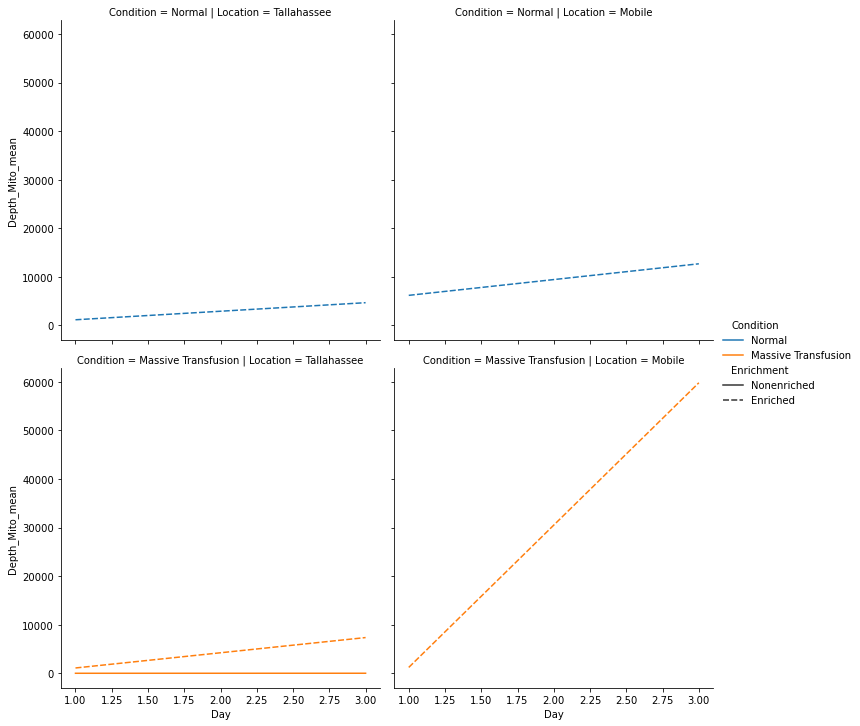

In [23]:
# g = sns.relplot(x="Day", y="Depth_Mito_mean", hue="Condition", units="Patient",
#             row="Condition", col="Location", style="Enrichment",
#             data=meanCovMerged, kind="line", estimator=None)
# plt.show()
# g.savefig("plots/cov-mito-means.svg")
# g.savefig("plots/cov-mito-means.png")

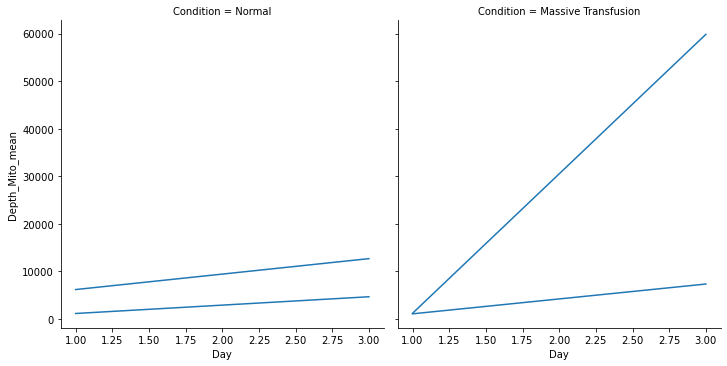

In [26]:
# g = sns.relplot(x="Day", y="Depth_Mito_mean", units="Patient",
#             col="Condition",
#             data=meanCovMerged.query('Enrichment == "Enriched"'), kind="line", estimator=None)
# plt.show()

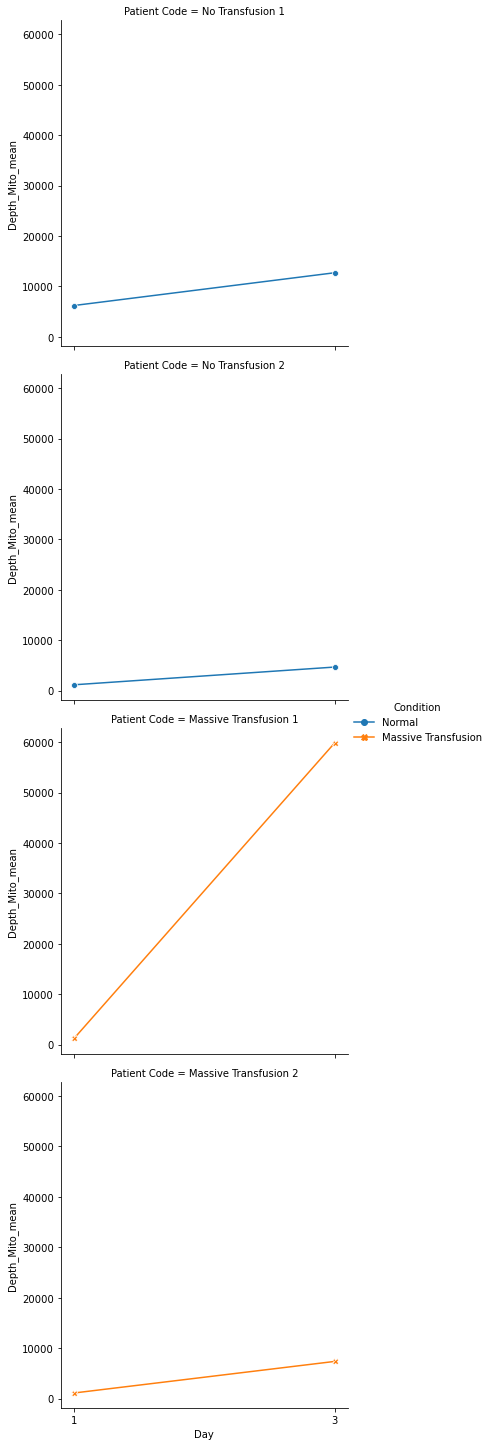

In [104]:
# formatted raw

enrichedCoverages = meanCovMerged.query('Enrichment == "Enriched"').copy()
cat_type_time = CategoricalDtype(categories=["1", "3"],
         ordered=True)
enrichedCoverages['Day'] = enrichedCoverages['Day'].astype(str).astype(cat_type_time)
g = sns.relplot(x="Day", y="Depth_Mito_mean", hue="Condition", style="Condition", units="Patient",
            row="Patient Code",  markers=True, dashes=False,
            data=enrichedCoverages,
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"]
                , kind="line", estimator=None)
g.savefig("plots/cov-mito-means.svg")
g.savefig("plots/cov-mito-means.png")
plt.show()

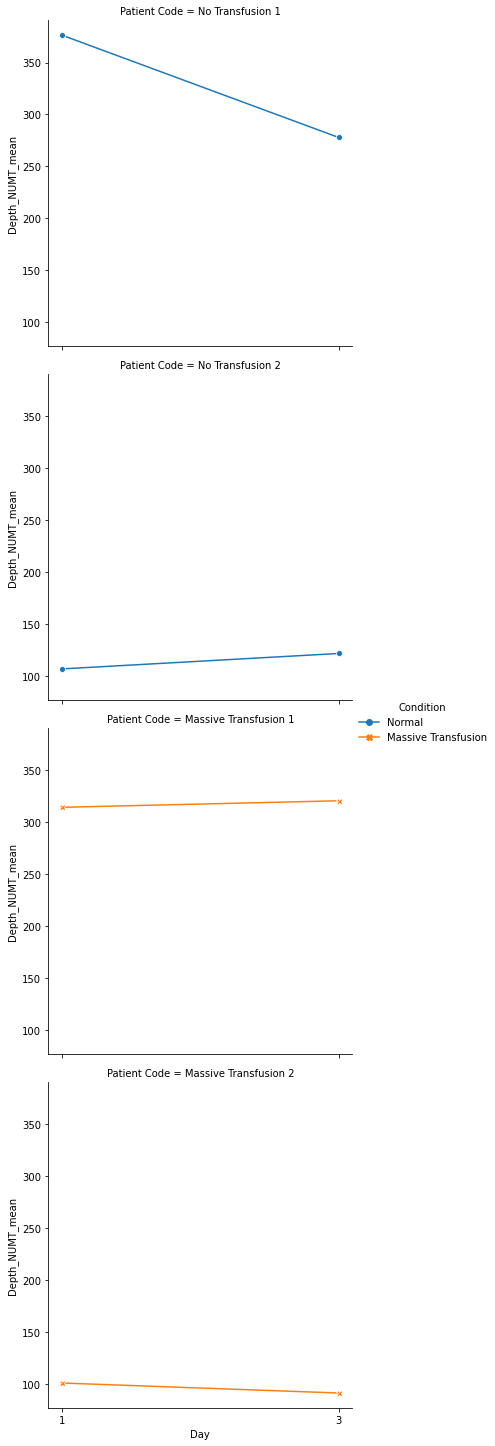

In [105]:
# g = sns.relplot(x="Day", y="Depth_NUMT_mean", hue="Condition", units="Patient",
#             row="Condition", col="Location", style="Enrichment",
#             data=meanCovMerged, kind="line", estimator=None)

# formatted numt
# formatted raw
g = sns.relplot(x="Day", y="Depth_NUMT_mean", hue="Condition", style="Condition", units="Patient",
            row="Patient Code",  markers=True, dashes=False,
            data=enrichedCoverages,
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"]
                , kind="line", estimator=None)
plt.show()
g.savefig("plots/cov-numt-means.svg")
g.savefig("plots/cov-numt-means.png")

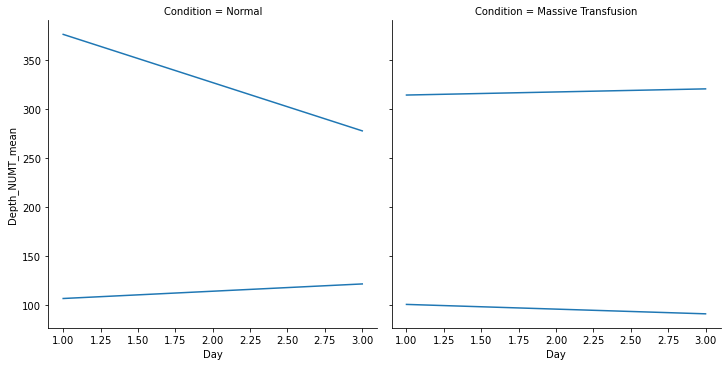

In [27]:
# g = sns.relplot(x="Day", y="Depth_NUMT_mean", units="Patient",
#             col="Condition",
#             data=meanCovMerged.query('Enrichment == "Enriched"'), kind="line", estimator=None)
# plt.show()

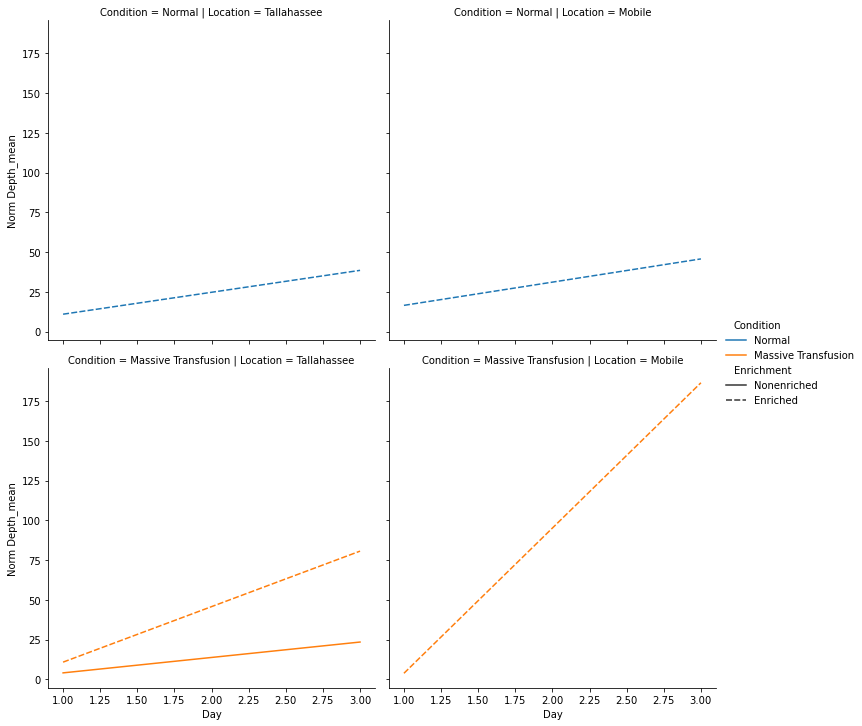

In [25]:
# g = sns.relplot(x="Day", y="Norm Depth_mean", hue="Condition", units="Patient",
#             row="Condition", col="Location", style="Enrichment",
#             data=meanCovMerged, kind="line", estimator=None)
# plt.show()
# g.savefig("plots/cov-mito-norm-means.svg")
# g.savefig("plots/cov-mito-norm-means.png")

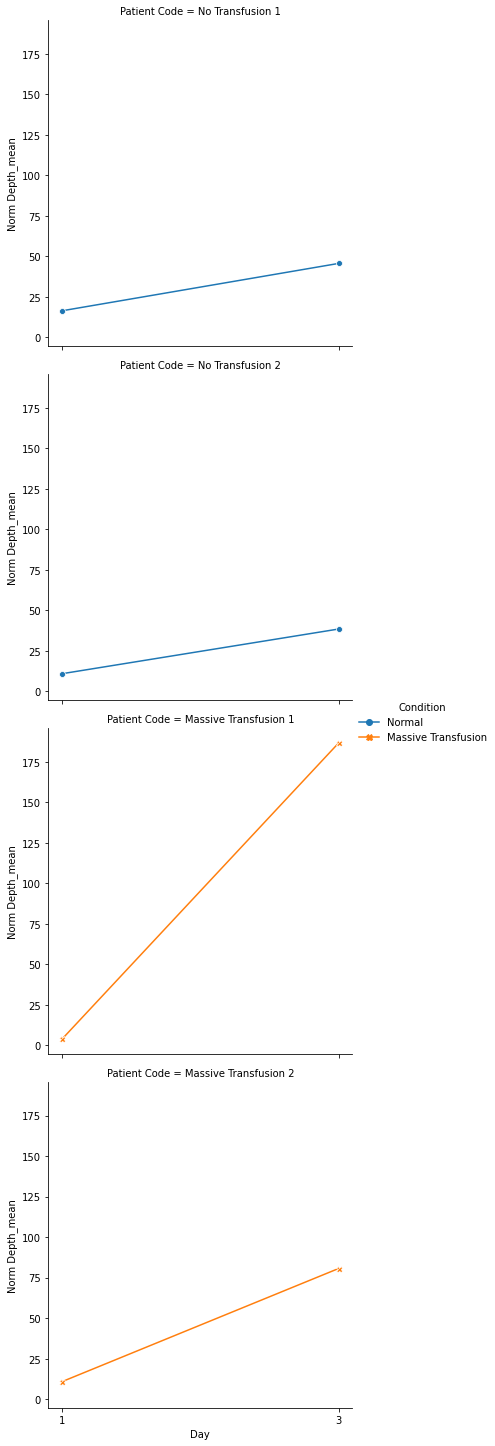

In [106]:
# normalized coverage
g = sns.relplot(x="Day", y="Norm Depth_mean", hue="Condition", style="Condition", units="Patient",
            row="Patient Code",  markers=True, dashes=False,
            data=enrichedCoverages,
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"]
                , kind="line", estimator=None)
g.savefig("plots/cov-mito-norm-means.svg")
g.savefig("plots/cov-mito-norm-means.png")
plt.show()

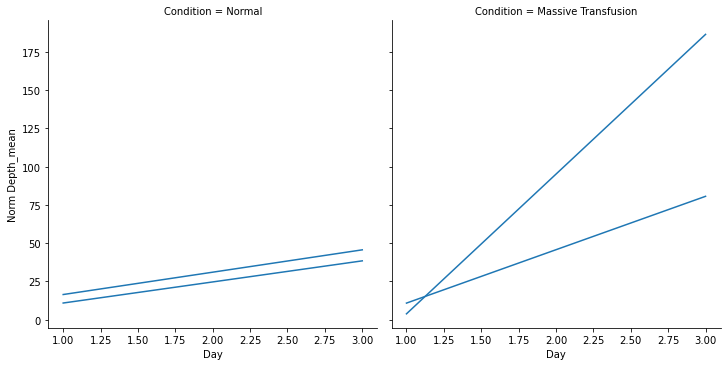

In [24]:
g = sns.relplot(x="Day", y="Norm Depth_mean", units="Patient",
            col="Condition",
            data=meanCovMerged.query('Enrichment == "Enriched"'), kind="line", estimator=None)
plt.show()

In [ ]:
g = sns.relplot(x="Day", y="Norm Depth_mean", hue="Condition", units="Patient",
            row="Condition", col="Location", style="Enrichment",
            data=meanCovMerged, kind="line", estimator=None)
plt.show()

In [50]:
# collapse by sample and NUMT
groupBys = ["Name", "Score", "Sample", "Depth"]
numtCovByHomology = numtCovCutdown.loc[:, groupBys]\
.groupby(["Name", "Score", "Sample"]).agg(["mean","median", "max"]).reset_index()
numtCovByHomology.columns = [f'{i} {j}' if j != '' else f'{i}' for i,j in numtCovByHomology.columns]
numtCovByHomology = numtCovByHomology.merge(designDF, how="left", on="Sample")

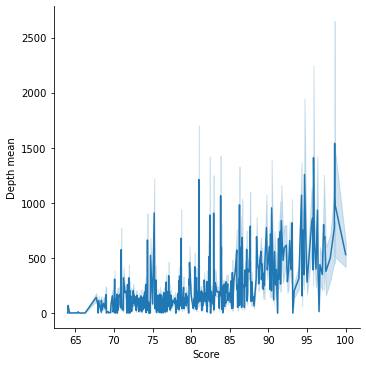

In [52]:
g = sns.relplot(x="Score", y="Depth mean",
            data=numtCovByHomology.query('Enrichment == "Enriched"'), kind="line")
g.savefig("plots/depthByHomology.png")

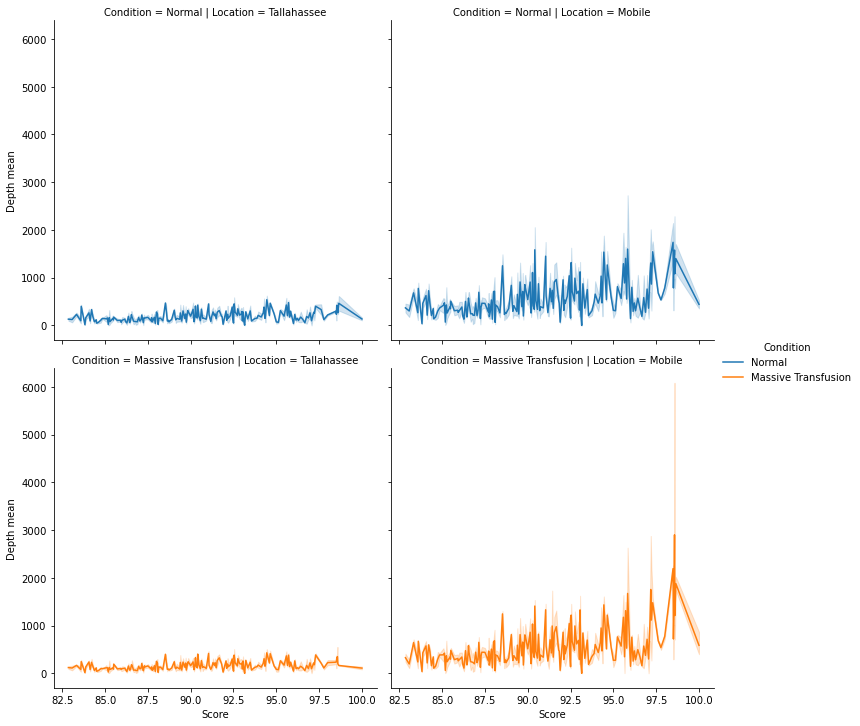

In [29]:
sns.relplot(x="Score", y="Depth mean", hue="Condition",
            row="Condition", col="Location",
            data=numtCovByHomology.query('Enrichment == "Enriched"'), kind="line")

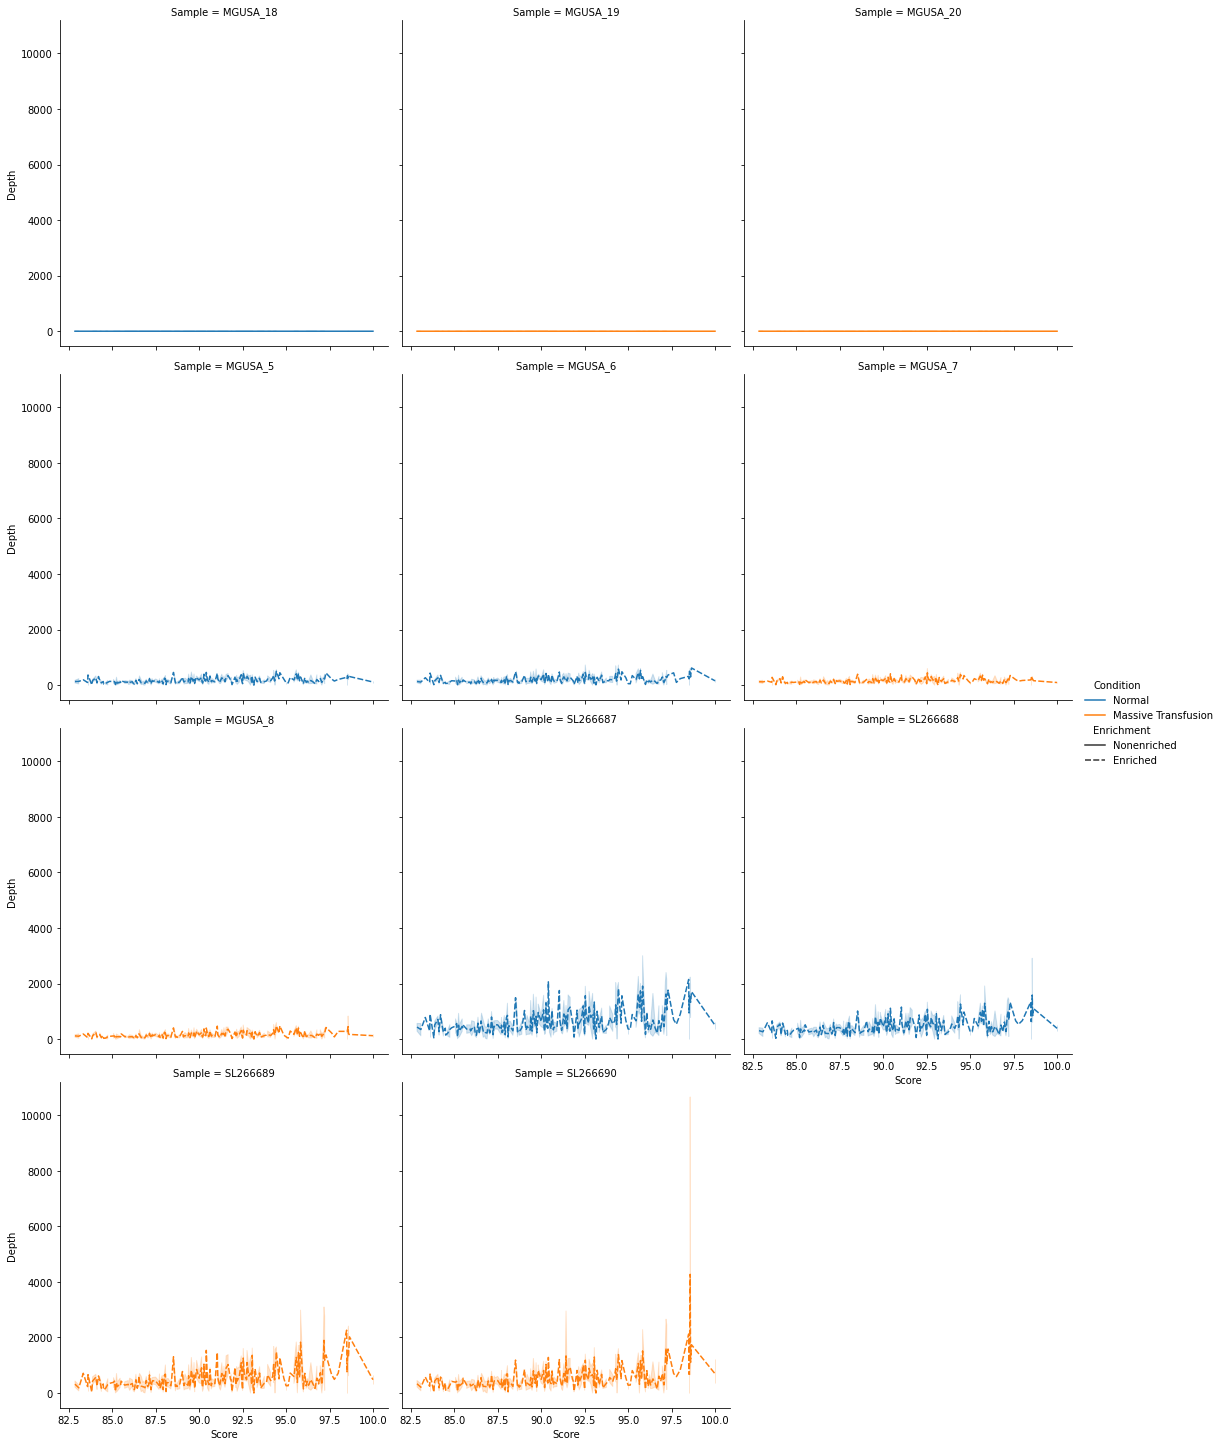

In [151]:
sns.relplot(x="Score", y="Depth", hue="Condition",
     col="Sample", col_wrap=3, style="Enrichment",
            data=numtCovByHomology, kind="line")

### Variant Calling

In [2]:
# # PyVCF-0.6.8
# import vcf
# import gzip

# now that I'm not using a normalized VCF, will need to use PyVCF to parse normal VCF

In [3]:
# # raw_variants = vcf.Reader(open('variants/grouped/grouped.ncbiformat.vcf'))
# raw_variants = vcf.Reader(filename='variants/grouped/norm.altsOnly.vcf.gz')

# # to add info tag for AF (aka VF?)
# #raw_variants.infos['HOB']
# # _Info = collections.namedtuple('Info', ['id', 'num', 'type', 'desc', 'source', 'version'])
# raw_variants.infos['AF'] = vcf.parser._Info(id="AF", num=1, type="Float", desc="Allele frequency for individual (named inconsistently in literature for site/sample aka VD",source=None, version=None)
# for record in raw_variants:
# #     print(record.INFO)
#     for sample_call in record:
#         tempTuple = sample_call.data
#         refCount = tempTuple.AD[0]
#         varCount = tempTuple.AD[1]
        
#         # tempAD (big issue is can I add this Info tag and have it work?
#         tempAD = varCount / (refCount + varCount)
#         if(tempAD >= 0.90):
#             tempTuple = tempTuple
#             pdb.set_trace()

> <ipython-input-3-de9b7eea6f26>(10)<module>()
      8 for record in raw_variants:
      9 #     print(record.INFO)
---> 10     for sample_call in record:
     11         tempTuple = sample_call.data
     12         refCount = tempTuple.AD[0]

ipdb> q


BdbQuit: 

In [6]:
def parseGroupedNormVCF(fileName):
    outList = []
    with open(fileName) as inFile:
        for line in inFile:
            parsedLine = line.strip().split("\t")
            contig = parsedLine[0]
            locus = parsedLine[1]
            variantID = parsedLine[2]
            reference = parsedLine[3]
            alternate = parsedLine[4]
            varType = parsedLine[5]
            
            formatString = parsedLine[6]
            attributeNames = formatString.split(":")
            numAttributes = len(attributeNames)
            start = 7
            end = start + numAttributes
            
            numSamples = len(parsedLine[7:]) // numAttributes
            for _ in range(numSamples):
                sampleLine = parsedLine[start:end]
#                 pdb.set_trace()
                start += numAttributes
                end += numAttributes
                
                entryDict = {"Chromosome": contig, "Start": locus, 
                             "ID": variantID,
                             "ref": reference, "alt": alternate, 
                                "Variant Type": varType }
                tempTuple = zip(attributeNames, sampleLine)
                for attr, val in tempTuple:
                    entryDict[attr] = val
                outList.append(entryDict)
    outDF = pd.DataFrame(outList)
    
    outDF.to_csv("/tmp/temp.csv", index=False)
    outDF = pd.read_csv("/tmp/temp.csv")
    outDF = outDF.set_index(["Chromosome", "Start", "ref", "alt"])
    return outDF            
#             print(formatString)


In [2]:
# raw_variants = pd.read_csv("variants/allVariants.tsv", sep="\t", names=["Chromosome","Start", "ref", "alt", 
#                                             "Variant Type", "Sample", "ADRef", "ADVar", "ADFor-Ref", "ADFor-Var",
#                                             "ADRev-Ref", "ADRev-Var"],
#                                               index_col=["Chromosome", "Start", "ref", "alt"])
# # this is calling variants from reads aligned only to the mitochondrial genome
# raw_variants_mitoOnly = pd.read_csv("mito-only-variants/allVariants.tsv", sep="\t", names=["Chromosome","Start", "ref", "alt", 
#                                             "Variant Type", "Sample", "ADRef", "ADVar", "ADFor-Ref", "ADFor-Var",
#                                             "ADRev-Ref", "ADRev-Var"],
#                                               index_col=["Chromosome", "Start", "ref", "alt"])


In [7]:
raw_variants = parseGroupedNormVCF("variants/grouped/variants.tsv")
raw_variants['Genotype'] = raw_variants['Genotype'].replace({"0/0": "Ref",
                            "0/1": "Heteroplasmy", "1/1": "Homoplasmy"})


raw_variants_mitoOnly = parseGroupedNormVCF("mito-only-variants/grouped/variants.tsv")
raw_variants_mitoOnly['Genotype'] = raw_variants_mitoOnly['Genotype'].replace({"0/0": "Ref",
                            "0/1": "Heteroplasmy", "1/1": "Homoplasmy"})

205650

In [40]:
# with open("variants/refsnp-chrMT.json") as file:
#     for line in file:
#         pdb.set_trace()
#         tempSNP = json.loads(line)
#         tempID = tempSNP['refsnp_id']

In [8]:
def callVariants(row):
    
#     cat_type_filter = CategoricalDtype(categories=["Pass", "Fail"])
#     row['Filter'] = "Fail"
#     row['Filter'] = row['Filter'].astype(cat_type_filter)
    
    numRef, numAlt = row['ADRef'] , row['ADVar']

    
        
    reverseAlt, forwardAlt = row['ADFor-Var'], row['ADRev-Var']
    reverseRef, forwardRef = row['ADFor-Ref'], row['ADRev-Ref']
#     strandBias = fisherTest(forwardRef, forwardAlt, reverseRef, reverseAlt)

    
#     strandBias =  abs(np.log10(((forwardAlt + 0.0001) / (forwardRef + 0.0001)) / 
#                                ((reverseAlt + 0.0001) / (reverseRef + 0.0001))))
#     row['Strand Bias'] = strandBias
    
#     if(fisherScore < 0.05):
#         row['Filter'] = 'Strand Imbalance'
#         return row

    
#     if((reverseAlt < 10) or (forAlt < 10)):
#         row['Filter'] = "Fail"
#         return row
    # strand bias

    # making requirement that depth must be at least 100
#     if(allelePerc < 1):
#         row['Filter'] = "Allele % Fail"
#         return row
    if( (numRef + numAlt) < 100):
        row['Filter'] = "Depth Fail"
        return row
    
        
    allelePerc = (numAlt / (numAlt + numRef)) * 100
    row['Fraction'] = allelePerc
    # if made it this far the site has passed
    
    if(numAlt < 10):
        row['Filter'] = "Not Enough Alt"
        return row
    row['Filter'] = "Pass"
    
    if(allelePerc < 99):
        row['Type'] = "Heteroplasmy"
    else:
        row['Type'] = "Homoplasmy"
    return row

def flagDayamaNumt(row):
    tempMaxAF = row['Max AF']
    if not(pd.isna(tempMaxAF)):
        if(row['Variant Type'] == "Homoplasmy"):
            row['Dayama Numt'] = False
        elif((row['Variant Type'] == "Heteroplasmy") and (row['Fraction'] <= tempMaxAF)):
            row['Dayama Numt'] = True
    else:
        row['Dayama Numt'] = False
    return row

def fisherTest(forRef, forVar, revRef, revVar):
#     print("{} {} {} {}".format(forRef, forVar, revRef, revVar))
#     pdb.set_trace()
    numerator = abs(((forVar + 0.0001) / (forRef + forVar + 0.0001)) - 
                    ((revVar + 0.0001) / (revRef + revVar + 0.0001)))
    
    denominator = (forVar + revVar + 0.0001) / (forRef + forVar + revRef + revVar + 0.0001)
    pval = (numerator)  / (denominator)
    
    flipPval = 1 - pval
    np.log10(flipPval)
    return np.log10(flipPval)
    

def getAnnotations(row):
    # citation for ensembl api
    #     If you use the Ensembl REST API please cite Yates et. al. (doi:10.1093/bioinformatics/btu613).

    # To cite Ensembl data usage, please use Zerbino et. al. (doi.org/10.1093/nar/gkx1098).

    # If you use the VEP in your work, please cite McLaren et. al. (doi:10.1186/s13059-016-0974-4).
    #     chrom, locus, ref, alt = row.name
    
    server = "https://rest.ensembl.org"
    ext = "/vep/human/region/{}:{}-{}:1/{}?".format("MT", row['Start'], row['Start'], row['alt'])

    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})

    if not r.ok:
        print("bad request")
        r.raise_for_status()
        sys.exit()
    else:
        print("made request")
    decoded = r.json()
    
    # this could be a detailed output
    # decoded[0]['transcript_consequences']
#     print(repr(decoded))
    mostSevereConsequence = decoded[0]['most_severe_consequence']
    row['Most Severe Consequence'] = mostSevereConsequence
    
    #need to sleep for a second or so to avoid rate limits
    time.sleep(1.05)
    return row
# def getMTVariantEffects():
#     server = "https://rest.ensembl.org"
#     ext = "/vep/homo_sapiens/region"
#     headers={ "Content-Type" : "application/json", "Accept" : "application/json"}
#     r = requests.post(server+ext, headers=headers, data='{ "variants" : ["21  26960070  rs116645811 G A . . .", "21  26965148  rs1135638 G A . . ." ] }')

#     if not r.ok:
#       r.raise_for_status()
#       sys.exit()

#     decoded = r.json()
#     print(repr(decoded))
    

In [83]:
# testing api access
# none seem to pass because low depth sample
# calledVariantsTest = raw_variants.head(10000).apply(callVariants, axis=1)
# calledVariantsTestUnique = calledVariantsTest.index.unique()

In [9]:
designDF = pd.read_csv("design.csv", sep="\t")
# cat_type_time = CategoricalDtype(categories=["1", "3"],
#          ordered=True)
# designDF['Day'] = designDF['Day'].astype(cat_type_time)

In [29]:
designDF.head()

,Sample,Enrichment,Condition,Day,Location,Patient,Age,Race,Lactate,Creatinine,Patient Code
0,SL266687,Enriched,Normal,1,Mobile,1,41,African-American,6.4,1.12,No Transfusion 1
1,SL266688,Enriched,Normal,3,Mobile,1,41,African-American,4.6,0.86,No Transfusion 1
2,SL266689,Enriched,Massive Transfusion,1,Mobile,2,33,White,5.9,1.08,Massive Transfusion 1
3,SL266690,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12,Massive Transfusion 1
4,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10,No Transfusion 2


In [10]:
rawSitesMerged = raw_variants.reset_index().merge(designDF, on="Sample")

In [11]:
rawSitesMerged.to_csv("variants/grouped/preliminary-calls.tsv", sep="\t", index=False)

In [12]:
fisherPivot = raw_variants.query('`Variant Type` == "SNP"').reset_index().pivot(index=["Chromosome", "Start", "ref", "alt"], columns="Sample", values=["SBFisher"])

In [11]:
# testCutdown = rawSitesMerged.query('(`Variant Type` == "SNP") and (Enrichment == "Enriched")').set_index(["Chromosome", "Start", "ref", "alt","Patient","Day"])
# testCutdown.loc[testCutdown.duplicated()]

ID Variant Type    Sample  \
Chromosome Start ref alt Patient Day                                        
chrM       21    A   C   3       1          NORSID          SNP   MGUSA_5   
           31    C   G   3       1          NORSID          SNP   MGUSA_5   
           35    G   T   3       1          NORSID          SNP   MGUSA_5   
           39    C   T   3       1          NORSID          SNP   MGUSA_5   
           42    T   C   3       1    rs1603218266          SNP   MGUSA_5   
...                                            ...          ...       ...   
           16545 T   G   2       3          NORSID          SNP  SL266690   
                     A   2       3          NORSID          SNP  SL266690   
           16551 T   A   2       3          NORSID          SNP  SL266690   
           16552 A   C   2       3          NORSID          SNP  SL266690   
           16553 A   T   2       3          NORSID          SNP  SL266690   

                                      ADRef  ADVar  ADFor-Ref  ADFor-Var  \
Chromosome Start ref alt Patient Day                                       
chrM       21    A   C   3       1      739      0        739          0   
           31    C   G   3       1      798      0        798          0   
           35    G   T   3       1      830      0        830          0   
           39    C   T   3       1      857      0        856          0   
           42    T   C   3       1      902      0        893          0   
...                                     ...    ...        ...        ...   
           16545 T   G   2       3      853      0        656          0   
                     A   2       3      853      0        656          0   
           16551 T   A   2       3      752      0        539          0   
           16552 A   C   2       3      729      0        514          0   
           16553 A   T   2       3      720      0        504          0   

                                      ADRev-Ref  ADRev-Var  SBFisher  \
Chromosome Start ref alt Patient Day                                   
chrM       21    A   C   3       1            0          0         0   
           31    C   G   3       1            0          0         0   
           35    G   T   3       1            0          0         0   
           39    C   T   3       1            1          0         0   
           42    T   C   3       1            9          0         0   
...                                         ...        ...       ...   
           16545 T   G   2       3          197          0         0   
                     A   2       3          197          0         0   
           16551 T   A   2       3          213          0         0   
           16552 A   C   2       3          215          0         0   
           16553 A   T   2       3          216          0         0   

                                      MinorFreq Genotype Enrichment  \
Chromosome Start ref alt Patient Day                                  
chrM       21    A   C   3       1          0.0      Ref   Enriched   
           31    C   G   3       1          0.0      Ref   Enriched   
           35    G   T   3       1          0.0      Ref   Enriched   
           39    C   T   3       1          0.0      Ref   Enriched   
           42    T   C   3       1          0.0      Ref   Enriched   
...                                         ...      ...        ...   
           16545 T   G   2       3          0.0      Ref   Enriched   
                     A   2       3          0.0      Ref   Enriched   
           16551 T   A   2       3          0.0      Ref   Enriched   
           16552 A   C   2       3          0.0      Ref   Enriched   
           16553 A   T   2       3          0.0      Ref   Enriched   

                                                Condition     Location  Age  \
Chromosome Start ref alt Patient Day                                          
chrM       21    A   C   3       1    

In [16]:
rawSitesMergedFormat.query('(Start == 9477) and (Patient == 2)').iloc[:,:15]

,Chromosome,Start,ref,alt,ID,Variant Type,Sample,ADRef,ADVar,ADFor-Ref,ADFor-Var,ADRev-Ref,ADRev-Var,SBFisher,MinorFreq
196600,chrM,9477,G,A,rs2853825,SNP,SL266689,8,607,4,361,4,246,1,0.986992
196601,chrM,9477,G,T,rs2853825,SNP,SL266689,8,0,4,0,4,0,1,0.000000
217165,chrM,9477,G,A,rs2853825,SNP,SL266690,0,889,0,889,0,0,0,1.000000
217166,chrM,9477,G,T,rs2853825,SNP,SL266690,0,1,0,1,0,0,0,1.000000


In [13]:
rawSitesMergedFormat = rawSitesMerged.copy()
rawSitesMergedFormat['Day'] = rawSitesMergedFormat['Day'].astype("str")
alleleDepthByDayPivot = rawSitesMergedFormat.query('(`Variant Type` == "SNP") and (Enrichment == "Enriched")and (ADRef >5 )').reset_index().pivot(index=["Chromosome", "Start", "ref", "alt","Patient","Condition","Patient Code"], columns="Day", values=["MinorFreq","Genotype"])
alleleDepthByDayPivot.columns = ["_".join(col) for col in alleleDepthByDayPivot.columns.values]

In [15]:
alleleDepthByDayPivotOnlyCalled = alleleDepthByDayPivot.query('(Genotype_1 != "Ref") or (Genotype_3 != "Ref")')
# alleleDepthByDayPivot.columns = ["AlleleFreq Day 1", "Allele"]

In [105]:
# colList = []
# for col in alleleDepthByDayPivot.columns.values:
#     tempOne = col[0]
#     tempTwo = str(col[1])
#     colList.append("_".join([tempOne, tempTwo]))
# alleleDepthByDayPivot.columns = colList
    

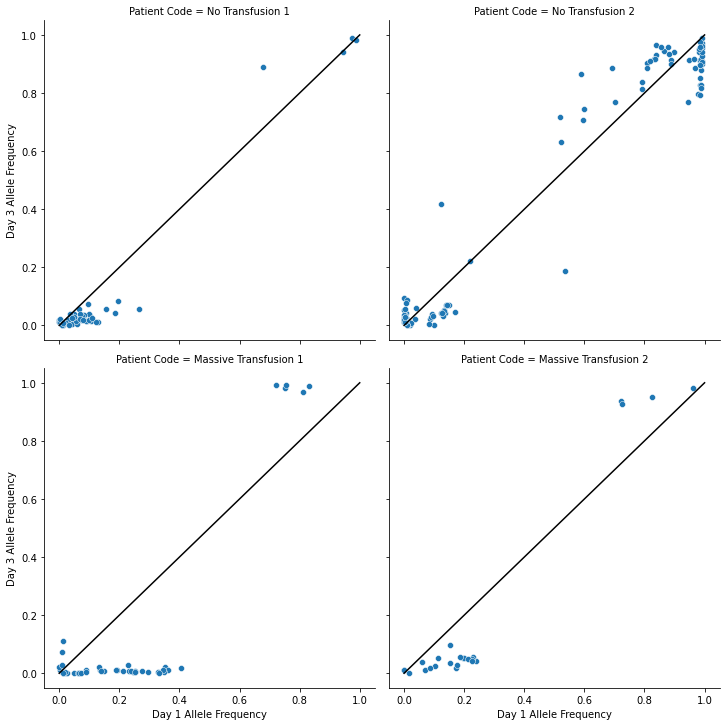

In [16]:
g = sns.relplot(x="MinorFreq_1", y='MinorFreq_3', col="Patient Code", col_wrap=2,
            data=alleleDepthByDayPivotOnlyCalled, kind="scatter", col_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"])

X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot

plotFunc = lambda x : x.plot(X_plot, Y_plot, color="black")

shape = np.shape(g.axes)

for i in range(shape[0]):
    plotFunc(g.axes[i])
        
        
g.set_axis_labels("Day 1 Allele Frequency", "Day 3 Allele Frequency")
plt.show()
g.savefig("plots/heteroplasmiesOneVsThree.png")

In [86]:
alleleDepthByDayPivotOnlyCalled

MinorFreq_1  \
Chromosome Start ref alt Patient Condition           Patient Code                        
chrM       60    T   A   2       Massive Transfusion Massive Transfusion 1  0.00111359   
                     C   2       Massive Transfusion Massive Transfusion 1  0.00774336   
                         3       Normal              No Transfusion 2        0.0110254   
           63    T   C   4       Massive Transfusion Massive Transfusion 2           0   
           70    G   A   2       Massive Transfusion Massive Transfusion 1  0.00228571   
...                                                                                ...   
           16526 G   A   2       Massive Transfusion Massive Transfusion 1    0.637566   
           16527 C   T   1       Normal              No Transfusion 1        0.0804348   
                         2       Massive Transfusion Massive Transfusion 1    0.331572   
                         3       Normal              No Transfusion 2        0.0972644   
                         4       Massive Transfusion Massive Transfusion 2    0.227194   

                                                                           MinorFreq_3  \
Chromosome Start ref alt Patient Condition           Patient Code                        
chrM       60    T   A   2       Massive Transfusion Massive Transfusion 1   0.0121413   
                     C   2       Massive Transfusion Massive Transfusion 1   0.0725389   
                         3       Normal              No Transfusion 2        0.0214505   
           63    T   C   4       Massive Transfusion Massive Transfusion 2   0.0113052   
           70    G   A   2       Massive Transfusion Massive Transfusion 1   0.0111562   
...                                                                                ...   
           16526 G   A   2       Massive Transfusion Massive Transfusion 1         NaN   
           16527 C   T   1       Normal              No Transfusion 1        0.0173536   
                         2       Massive Transfusion Massive Transfusion 1           0   
                         3       Normal              No Transfusion 2        0.0319735   
                         4       Massive Transfusion Massive Transfusion 2    0.043956   

                                                                              Genotype_1  \
Chromosome Start ref alt Patient Condition           Patient Code                          
chrM       60    T   A   2       Massive Transfusion Massive Transfusion 1           Ref   
                     C   2       Massive Transfusion Massive Transfusion 1           Ref   
                         3       Normal              No Transfusion 2       Heteroplasmy   
           63    T   C   4       Massive Transfusion Massive Transfusion 2           Ref   
           70    G   A   2       Massive Transfusion Massive Transfusion 1           Ref   
...                                                                                  ...   
           16526 G   A   2       Massive Transfusion Massive Transfusion 1  Heteroplasmy   
           16527 C   T   1       Normal              No Transfusion 1       Heteroplasmy   
                         2       Massive Transfusion Massive Transfusion 1  Heteroplasmy   
                         3       Normal              No Transfusion 2       Heteroplasmy   
                         4       Massive Transfusion Massive Transfusion 2  Heteroplasmy   

                                                                              Genotype_3  
Chromosome Start ref alt Patient Condition           Patient Code                         
chrM       60    T   A   2       Massive Transfusion Massive Transfusion 1  Heteroplasmy  
                     C   2       Massive Transfusion Massive Transfusion 1  Heteroplasmy  
                         3       Normal              No Transfusion 2       Heteroplasmy  
           63    T   C   4       Massive Transfusion Massive Transfusion 2  Heter

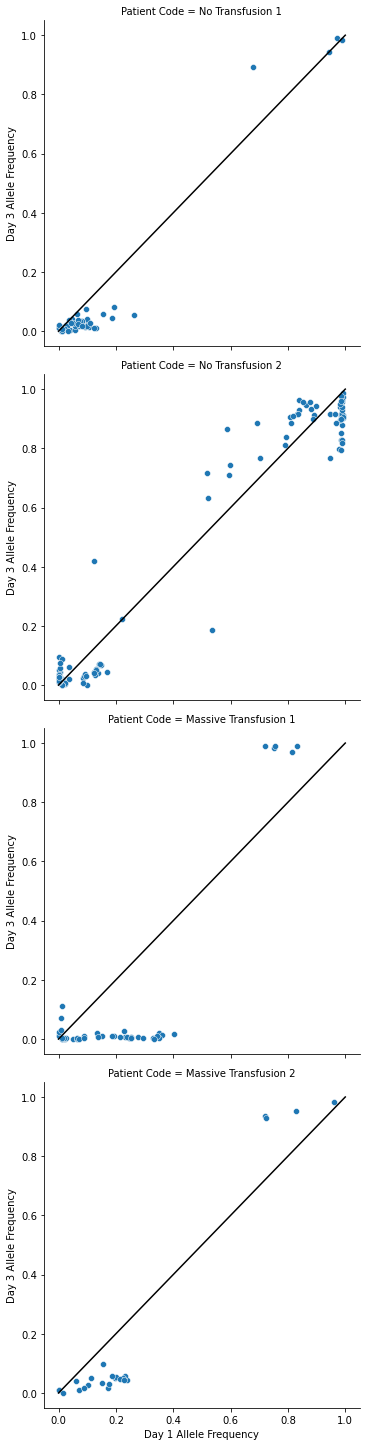

In [17]:
g = sns.relplot(x="MinorFreq_1", y='MinorFreq_3',
            data=alleleDepthByDayPivotOnlyCalled, kind="scatter", row="Patient Code",
            row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"])

X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot

plotFunc = lambda x : x.plot(X_plot, Y_plot, color="black")

shape = np.shape(g.axes)
for i in range(shape[0]):
#     pdb.set_trace()
    plotFunc(g.axes[i][0])
        
        
g.set_axis_labels("Day 1 Allele Frequency", "Day 3 Allele Frequency")
g.savefig("plots/heteroplasmiesOneVsThree-format.png")
g.savefig("plots/heteroplasmiesOneVsThree-format.svg")

plt.show()


# g = sns.relplot(x="Day", y="Heteroplasmy", hue="Condition", units="Patient",
#             row="Patient Code",  markers=True, dashes=False,
#             data=varCounts.query('Enrichment == "Enriched"'),
#                 row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"]
#                 , kind="line", estimator=None)

In [25]:
alleleDepthByDayPivotOnlyCalled.query('(MinorFreq_1 < 0.7) and (MinorFreq_3 > 0.8)')

MinorFreq_1  \
Chromosome Start ref alt Patient Condition           Location                  
chrM       6827  T   C   3       Normal              Tallahassee     0.58871   
           9477  G   T   2       Massive Transfusion Mobile                0   
           11719 G   T   2       Massive Transfusion Mobile              0.2   
           12519 T   C   3       Normal              Tallahassee    0.690608   
           14766 C   G   2       Massive Transfusion Mobile              0.2   
           14872 C   T   1       Normal              Mobile         0.678723   
           16526 G   A   2       Massive Transfusion Mobile         0.637566   

                                                                 MinorFreq_3  \
Chromosome Start ref alt Patient Condition           Location                  
chrM       6827  T   C   3       Normal              Tallahassee    0.864198   
           9477  G   T   2       Massive Transfusion Mobile                1   
           11719 G   T   2       Massive Transfusion Mobile                1   
           12519 T   C   3       Normal              Tallahassee    0.885882   
           14766 C   G   2       Massive Transfusion Mobile                1   
           14872 C   T   1       Normal              Mobile         0.891079   
           16526 G   A   2       Massive Transfusion Mobile                1   

                                                                    Genotype_1  \
Chromosome Start ref alt Patient Condition           Location                    
chrM       6827  T   C   3       Normal              Tallahassee  Heteroplasmy   
           9477  G   T   2       Massive Transfusion Mobile                Ref   
           11719 G   T   2       Massive Transfusion Mobile                Ref   
           12519 T   C   3       Normal              Tallahassee  Heteroplasmy   
           14766 C   G   2       Massive Transfusion Mobile                Ref   
           14872 C   T   1       Normal              Mobile       Heteroplasmy   
           16526 G   A   2       Massive Transfusion Mobile       Heteroplasmy   

                                                                    Genotype_3  
Chromosome Start ref alt Patient Condition           Location                   
chrM       6827  T   C   3       Normal              Tallahassee  Heteroplasmy  
           9477  G   T   2       Massive Transfusion Mobile         Homoplasmy  
           11719 G   T   2       Massive Transfusion Mobile         Homoplasmy  
           12519 T   C   3       Normal              Tallahassee  Heteroplasmy  
           14766 C   G   2       Massive Transfusion Mobile         Homoplasmy  
           14872 C   T   1       Normal              Mobile       Heteroplasmy  
           16526 G   A   2       Massive Transfusion Mobile         Homoplasmy

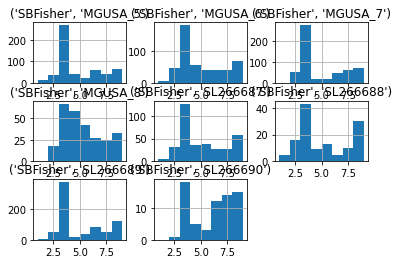

In [10]:
fisherPivot.hist(bins=np.arange(1,10,1))
plt.show()

<AxesSubplot:xlabel='ref', ylabel='SBFisher'>

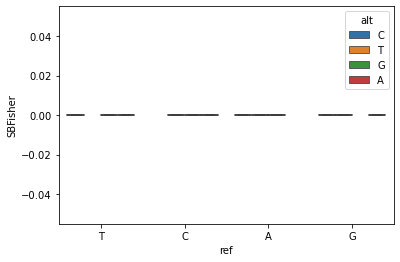

In [32]:
sns.boxplot(x="ref", y="SBFisher", hue="alt",showfliers=False, data=rawSitesMerged.query('(Enrichment == "Enriched") and (`Variant Type` == "SNP")'))

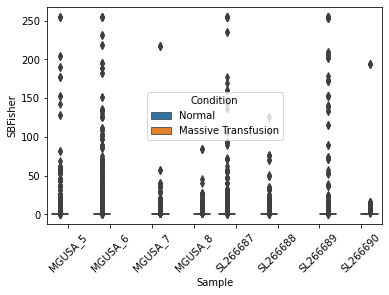

In [35]:
sns.boxplot(x="Sample", y="SBFisher", hue="Condition",showfliers=True, data=rawSitesMerged.query('Enrichment == "Enriched"'))
plt.xticks(rotation = 45)

plt.show()
# using this plot as justification to filter vcf for sites where at least one sample had 

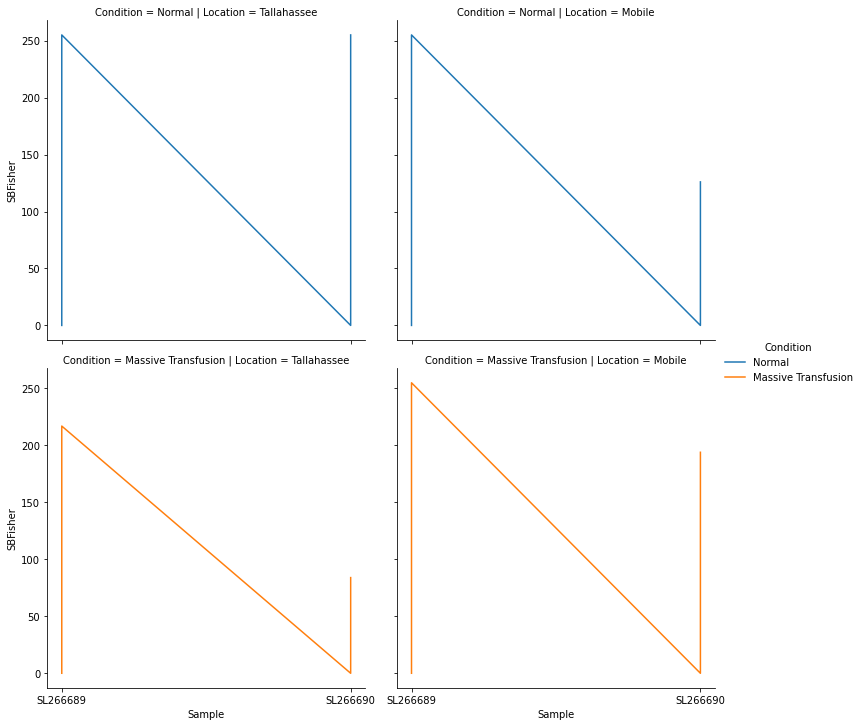

In [36]:
g = sns.relplot(x="Sample", y="SBFisher", hue="Condition", units="Patient",
            row="Condition", col="Location",
            data=rawSitesMerged.query('Enrichment == "Enriched"'), kind="line", estimator=None)

<AxesSubplot:xlabel='ref', ylabel='SBFisher'>

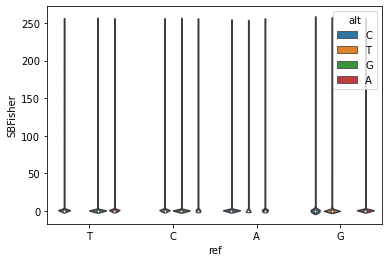

In [44]:
sns.violinplot(x="ref", y="SBFisher", hue="alt", data=rawSitesMerged.query('(Enrichment == "Enriched") and (`Variant Type` == "SNP")'))

Reference Base A


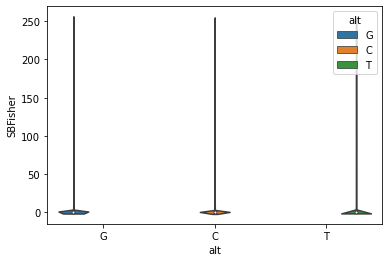

Reference Base C


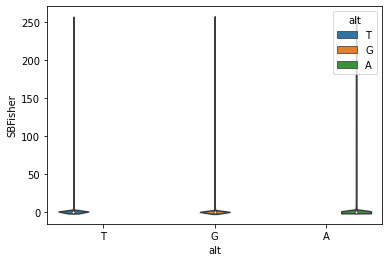

Reference Base G


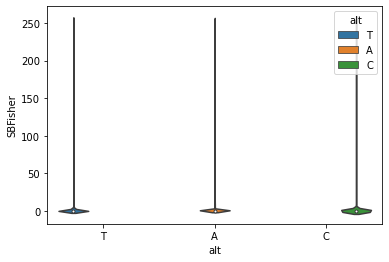

Reference Base T


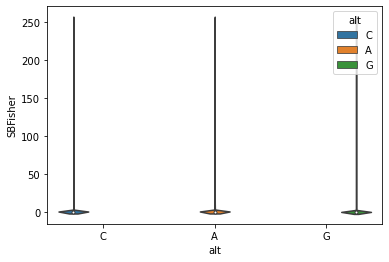

In [45]:
for name, group in rawSitesMerged.query('(Enrichment == "Enriched") and (`Variant Type` == "SNP")').groupby("ref"):
    print("Reference Base {}".format(name))
    sns.violinplot(x="alt", y="SBFisher", hue="alt", data=group)
    plt.show()

Reference Base A Alt Base C


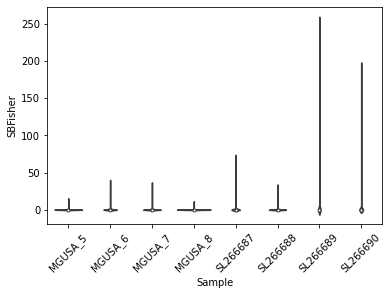

Reference Base A Alt Base G


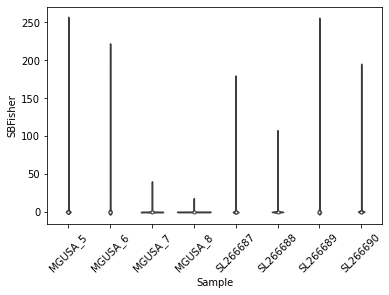

Reference Base A Alt Base T


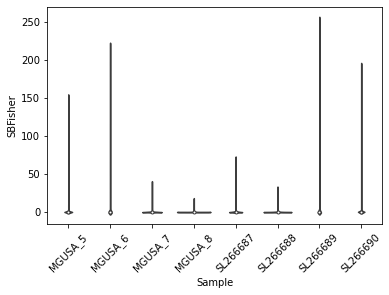

Reference Base C Alt Base A


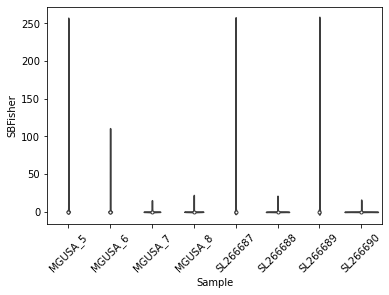

Reference Base C Alt Base G


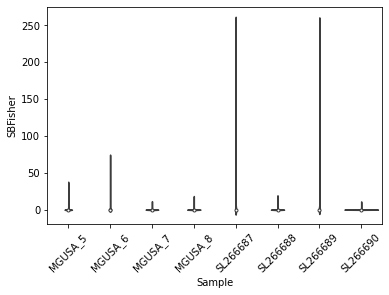

Reference Base C Alt Base T


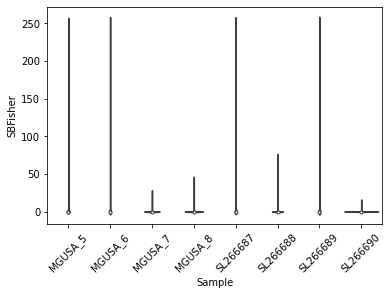

Reference Base G Alt Base A


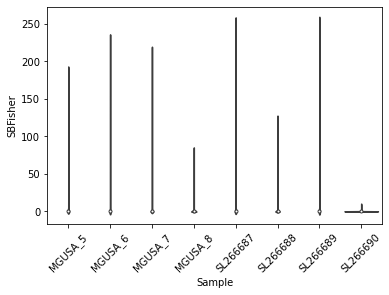

Reference Base G Alt Base C


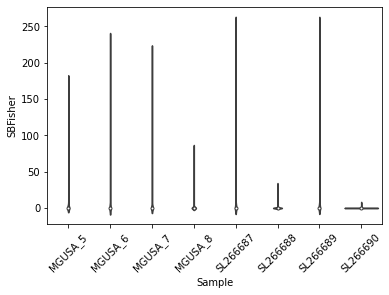

Reference Base G Alt Base T


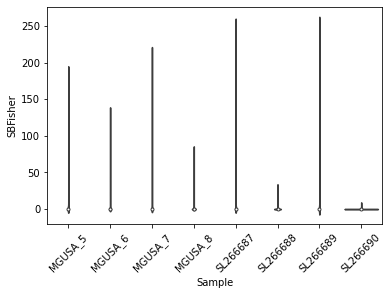

Reference Base T Alt Base A


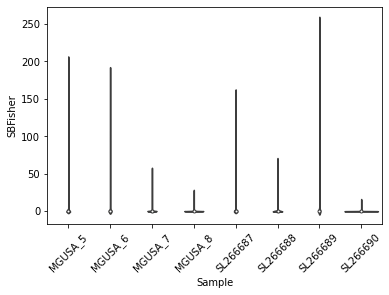

Reference Base T Alt Base C


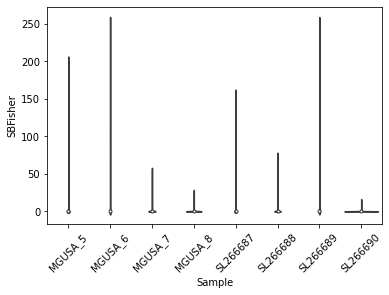

Reference Base T Alt Base G


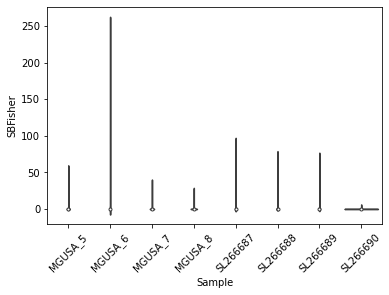

In [46]:
for name, group in rawSitesMerged.query('(Enrichment == "Enriched") and (`Variant Type` == "SNP")').groupby(["ref", "alt"]):
    print("Reference Base {} Alt Base {}".format(*name))
    fig, ax = plt.subplots()
    ax = sns.violinplot(x="Sample", y="SBFisher", data=group)
    plt.xticks(rotation = 45)
    plt.show()

<AxesSubplot:xlabel='Sample', ylabel='SBFisher'>

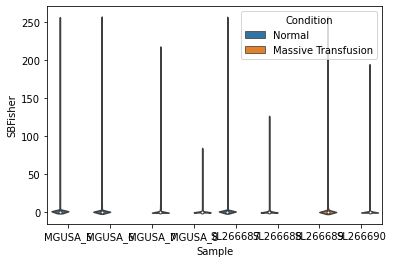

In [47]:
sns.violinplot(x="Sample", y="SBFisher", hue="Condition",showfliers=False, data=rawSitesMerged.query('Enrichment == "Enriched"'))

In [19]:
calledVariants = raw_variants.query('Genotype != "Ref"')
calledVariantsMitoOnly = raw_variants_mitoOnly.query('Genotype != "Ref"')

In [20]:
calledVariantsUnique = calledVariants.index.unique()
allVariantEffects = calledVariantsUnique.to_frame(index=False).apply(getAnnotations, axis=1)
allVariantEffects = allVariantEffects.set_index(["Chromosome", "Start", "ref", "alt"])

made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request
made request

In [21]:
allVariantEffects.to_csv("variants/variant-effects.csv")

In [22]:
allVariantEffects = pd.read_csv("variants/variant-effects.csv")
allVariantEffects = allVariantEffects.set_index(["Chromosome", "Start", "ref", "alt"])

In [23]:
dayamaSites = pd.read_excel("variants/dayama-numts.xlsx")
# dayamaSites['Dayama Numt'] = True
# calledVariantsMerged = 

In [24]:
calledVariantsEffect = calledVariants.merge(allVariantEffects, left_index=True, right_index=True)
calledVariantsMerged = calledVariantsEffect.merge(dayamaSites, how="left", on=["Start", "ref", "alt"])
# calledVariantsMerged['Dayama Numt'] = calledVariantsMerged['Dayama Numt'].fillna(value=False)
calledVariantsMerged = calledVariantsMerged.apply(flagDayamaNumt, axis=1)

In [25]:
# calledVariants

# heteroplasmyCallsCounts = calledVariantsMerged.query('`Genotype` == "Heteroplasmy"').groupby('Sample').count().merge(designDF, on="Sample", how="left")
# homoplasmyCallsCounts = calledVariantsMerged.query('`Genotype` == "Homoplasmy"').groupby('Sample').count().merge(designDF, on="Sample", how="left")

In [26]:
varCounts = pd.pivot_table(calledVariantsMerged, index="Sample", columns="Genotype", values="ADVar", aggfunc="count").merge(designDF, on="Sample", how="left")


In [27]:
varCounts

,Sample,Heteroplasmy,Homoplasmy,Enrichment,Condition,Day,Location,Patient,Age,Race,Lactate,Creatinine,Patient Code
0,MGUSA_20,NaN,6.0,Nonenriched,Massive Transfusion,3,Tallahassee,4,38,White,2.4,1.17,Massive Transfusion 2
1,MGUSA_5,59.0,19.0,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10,No Transfusion 2
2,MGUSA_6,139.0,6.0,Enriched,Normal,3,Tallahassee,3,41,African-American,3.3,0.92,No Transfusion 2
3,MGUSA_7,24.0,14.0,Enriched,Massive Transfusion,1,Tallahassee,4,38,White,2.9,1.04,Massive Transfusion 2
4,MGUSA_8,25.0,21.0,Enriched,Massive Transfusion,3,Tallahassee,4,38,White,2.4,1.17,Massive Transfusion 2
5,SL266687,48.0,8.0,Enriched,Normal,1,Mobile,1,41,African-American,6.4,1.12,No Transfusion 1
6,SL266688,46.0,4.0,Enriched,Normal,3,Mobile,1,41,African-American,4.6,0.86,No Transfusion 1
7,SL266689,51.0,8.0,Enriched,Massive Transfusion,1,Mobile,2,33,White,5.9,1.08,Massive Transfusion 1
8,SL266690,20.0,20.0,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12,Massive Transfusion 1


In [28]:
# homoplasmyPivot = calledVariantsMerged.query('`Variant Type` == "Homoplasmy"').pivot(index=["Start", "ref", "alt", 'SBFisher',
#         'Variant Type','Most Severe Consequence',  'NUMT IDs', 'Max AF', 'Dayama Numt'], columns="Sample", 
#                 values=['Genotype'])

In [29]:
homoplasmyPivot

NameError: name 'homoplasmyPivot' is not defined

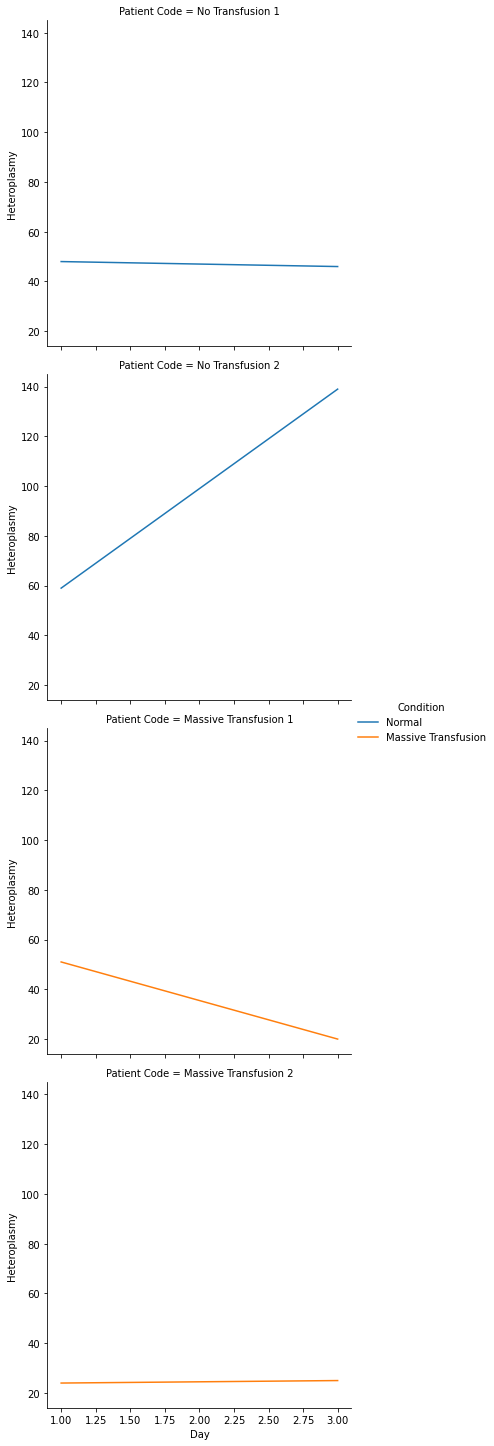

In [30]:
g = sns.relplot(x="Day", y="Heteroplasmy", hue="Condition", units="Patient",
            row="Patient Code",  markers=True, dashes=False,
            data=varCounts.query('Enrichment == "Enriched"'),
                row_order=["No Transfusion 1", "No Transfusion 2","Massive Transfusion 1", "Massive Transfusion 2"]
                , kind="line", estimator=None)


# g = sns.relplot(x="Day", y="Heteroplasmy", hue="Condition", units="Patient",
#             row="Condition", col="Location", style="Enrichment",
#             data=varCounts, kind="line", estimator=None)
g.savefig("plots/heteroplasmy-changes.svg")
g.savefig("plots/heteroplasmy-changes.png")

In [31]:
g = sns.relplot(x="Day", y="Type", hue="Condition", units="Patient",
            col="Condition",
            data=heteroplasmyCallsCounts, kind="line", estimator=None)

NameError: name 'heteroplasmyCallsCounts' is not defined

In [32]:
calledVariantsMitoOnlyMerged = calledVariantsMitoOnly.merge(dayamaSites, how="left", on=["Start", "ref", "alt"])
calledVariantsMitoOnlyMerged = calledVariantsMitoOnlyMerged.apply(flagDayamaNumt, axis=1)
varCountsMitoOnly = pd.pivot_table(calledVariantsMitoOnlyMerged, index="Sample", columns="Genotype", values="ADVar", aggfunc="count").reset_index()


In [34]:
outDirWorkbooks = Path("workbooks")
import datetime
now = datetime.datetime.now()
writer = pd.ExcelWriter(outDirWorkbooks / ('heteroplasmy-calls-trali' + str(now)+ '.xlsx'), engine='xlsxwriter')
varCounts.to_excel(writer, "Summary Counts", index=False)
for name,group in calledVariantsMerged.groupby("Sample"):
    print(name)
    group.to_excel(writer, name, index=False)
writer.save()

MGUSA_20
MGUSA_5
MGUSA_6
MGUSA_7
MGUSA_8
SL266687
SL266688
SL266689
SL266690


In [19]:
# outDirWorkbooks = Path("workbooks")

# writer = pd.ExcelWriter(outDirWorkbooks / 'heteroplasmy-calls-trali-mitoOnly.xlsx', engine='xlsxwriter')
# varCountsMitoOnly.to_excel(writer, "Summary Counts", index=False)

# for name,group in calledVariantsMitoOnlyMerged.reset_index().groupby("Sample"):
#     print(name)
#     group.to_excel(writer, name, index=None)
# writer.save()

NameError: name 'varCountsMitoOnly' is not defined

### Sim Coverages and iSegs (whole genome)

In [4]:
from pathlib import Path
alignDirSim = Path("/home/gtd1521_jagmail_southalabama_edu/scratch/simulated/")
outDirSim = Path("simulated-coverages")
if not outDirSim.is_dir():
    outDirSim.mkdir()

simDesign = pd.read_csv(outDirSim / "sim-design.csv", sep=",")

In [6]:
mtSimQual20 = driveBedCoverage("mito.full.human.bed", alignDirSim,"design.csv", mapQual=20)
mtSimQual20.to_csv(outDirSim / "Sim-Coverage-Raw-Qual20.tsv", sep="\t", index=None)

mtSimQual0 = driveBedCoverage("mito.full.human.bed", alignDirSim,"design.csv", mapQual=0)
mtSimQual0.to_csv(outDirSim / "Sim-Coverage-Raw-Qual0.tsv", sep="\t", index=None)

*********************
Sample Mito-Only-Sim-50bp-300_RG1
*********************
Sample Numt-Only-Sim-50bp-150_RG1
*********************
Sample Numt-Only-Sim-50bp-300_RG1
*********************
Sample Numt-Only-Sim-50bp-100_RG1
*********************
Sample Numt-Only-Sim-100bp-300_RG1
*********************
Sample Mito-Only-Sim-100bp-150_RG1
*********************
Sample Mito-Only-Sim-50bp-100_RG1
*********************
Sample Mito-Only-Sim-50bp-150_RG1
*********************
Sample Mito-Only-Sim-100bp-300_RG1
*********************
Sample Numt-Only-Sim-100bp-150_RG1
*********************
Sample Mito-Only-Sim-50bp-300_RG1
*********************
Sample Numt-Only-Sim-50bp-150_RG1
*********************
Sample Numt-Only-Sim-50bp-300_RG1
*********************
Sample Numt-Only-Sim-50bp-100_RG1
*********************
Sample Numt-Only-Sim-100bp-300_RG1
*********************
Sample Mito-Only-Sim-100bp-150_RG1
*********************
Sample Mito-Only-Sim-50bp-100_RG1
*********************
Sample Mito-Only-Sim

In [31]:
simDesign

,Sample,Read Size,Insert Size,Generated From,Aligned To
0,Mito-Only-Sim-100bp-100_RG1,100,100,Mito,All
1,Mito-Only-Sim-100bp-150_RG1,100,150,Mito,All
2,Mito-Only-Sim-100bp-300_RG1,100,300,Mito,All
3,Mito-Only-Sim-100bp-75_RG1,100,75,Mito,All
4,Mito-Only-Sim-50bp-100_RG1,50,100,Mito,All
5,Mito-Only-Sim-50bp-150_RG1,50,150,Mito,All
6,Mito-Only-Sim-50bp-300_RG1,50,300,Mito,All
7,Mito-Only-Sim-50bp-75_RG1,50,75,Mito,All
8,NUMT-Only-Sim-100bp-100-MitoOnly_RG1,100,100,Numt,Mito Only
9,NUMT-Only-Sim-100bp-100_RG1,100,100,Numt,All


In [5]:
mtSimQual20 = pd.read_csv(outDirSim / "Sim-Coverage-Raw-Qual20.tsv", sep="\t")
mtSimQual20['Quality'] = 20
mtSimQual0 = pd.read_csv(outDirSim / "Sim-Coverage-Raw-Qual0.tsv", sep="\t")
mtSimQual0['Quality'] = 0

In [6]:
allQualities = pd.concat([mtSimQual0, mtSimQual20], axis=0)

In [75]:
allQualities

,Chromosome,Start,End,Score,Strand,Offset,Sample,Depth,Quality
0,chrM,0,16569,100,.,0,Mito-Only-Sim-50bp-300_RG1,6,0
1,chrM,0,16569,100,.,1,Mito-Only-Sim-50bp-300_RG1,21,0
2,chrM,0,16569,100,.,2,Mito-Only-Sim-50bp-300_RG1,30,0
3,chrM,0,16569,100,.,3,Mito-Only-Sim-50bp-300_RG1,36,0
4,chrM,0,16569,100,.,4,Mito-Only-Sim-50bp-300_RG1,46,0
...,...,...,...,...,...,...,...,...,...
165685,chrM,0,16569,100,.,16564,Numt-Only-Sim-100bp-150_RG1,0,20
165686,chrM,0,16569,100,.,16565,Numt-Only-Sim-100bp-150_RG1,0,20
165687,chrM,0,16569,100,.,16566,Numt-Only-Sim-100bp-150_RG1,0,20
165688,chrM,0,16569,100,.,16567,Numt-Only-Sim-100bp-150_RG1,0,20


In [7]:
mergedAllQualities = allQualities.merge(simDesign, on="Sample")
mergedAllQualities['Formatted Name'] = mergedAllQualities.apply(lambda row:"Read Size "+str(row['Read Size'])+"bp Insert Size "+str(row['Insert Size'])+"bp",axis=1)

In [8]:
mitoSimAll = mergedAllQualities.query('`Generated From` == "Mito"')
numtSimAll = mergedAllQualities.query('`Generated From` == "Numt"')

In [9]:
mitoSimAll['% Error'] = (mitoSimAll['Depth'] - 1000) / 10
numtSimAll['% Error'] = numtSimAll['Depth'] / 10

/home/gtd1521_jagmail_southalabama_edu/mitochondrial/novogene-9-9-20/Processing_Sept_2020/envs/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/gtd1521_jagmail_southalabama_edu/mitochondrial/novogene-9-9-20/Processing_Sept_2020/envs/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
mitoSimAll['Formatted Name'].value_counts()

Read Size 50bp Insert Size 300bp     33138
Read Size 100bp Insert Size 150bp    33138
Read Size 100bp Insert Size 300bp    33138
Read Size 50bp Insert Size 150bp     33138
Read Size 50bp Insert Size 100bp     33138
Name: Formatted Name, dtype: int64

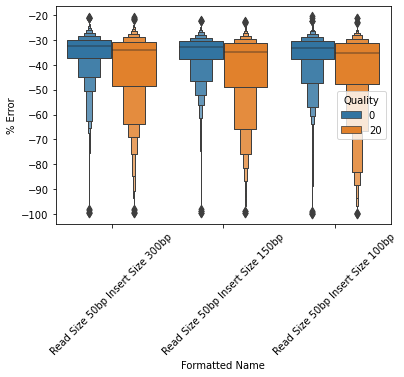

In [11]:
ax = sns.boxenplot(x="Formatted Name", y="% Error" ,hue="Quality",data= mitoSimAll.query('`Read Size` == 50'),
                 order=['Read Size 50bp Insert Size 300bp', 'Read Size 50bp Insert Size 150bp',
                       'Read Size 50bp Insert Size 100bp'] )
# ax.set_yscale('log')
plt.xticks(rotation = 45)
plt.savefig("plots/simulation-false-neg-4-20-21.png")
plt.show()


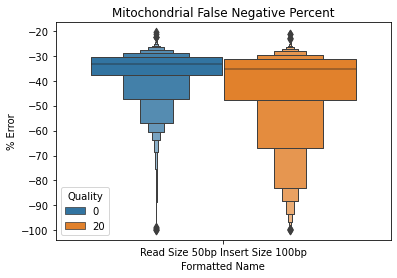

In [12]:
# cutdown to just the 100bp insert for demonstration
ax = sns.boxenplot(x="Formatted Name", y="% Error" ,hue="Quality",data= mitoSimAll.query('(`Read Size` == 50) and (`Insert Size` == 100)'), )
# ax.set_yscale('log')
ax.set_title("Mitochondrial False Negative Percent")
plt.savefig("plots/simulation-false-neg-cutdown-4-20-21.png")
plt.show()


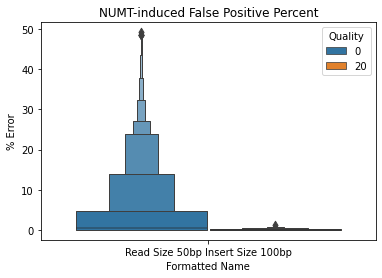

In [107]:
ax = sns.boxenplot(x="Formatted Name", y="% Error", hue="Quality",data= numtSimAll.query('(`Read Size` == 50) and (`Insert Size` == 100)'))
ax.set_title("NUMT-induced False Positive Percent")
# plt.xticks(rotation = 45)
plt.savefig("plots/simulation-false-pos-cutdown-4-20-21.png")
plt.show()


In [13]:
mtSimQual0Stats = mtSimQual0.groupby('Sample')['Depth'].describe()
mtSimQual20Stats = mtSimQual20.groupby('Sample')['Depth'].describe()

In [14]:
mtSimQual0Temp = mtSimQual0Stats.copy()
mtSimQual0Temp['Map Qual'] = 0

mtSimQual20Temp = mtSimQual20Stats.copy()
mtSimQual20Temp['Map Qual'] = 20

mtSimQualConcat = pd.concat([mtSimQual0Temp, mtSimQual20Temp], axis=0).merge(simDesign, how="left", on="Sample")


,count,mean,std,min,25%,50%,75%,max,Map Qual
Sample,,,,,,,,,
Mito-Only-Sim-100bp-150_RG1,16569.0,899.932102,155.081841,2.0,913.0,945.0,972.0,1080.0,20
Mito-Only-Sim-100bp-300_RG1,16569.0,920.910194,129.821183,2.0,927.0,954.0,978.0,1066.0,20
Mito-Only-Sim-50bp-100_RG1,16569.0,571.184380,175.029206,2.0,521.0,648.0,686.0,785.0,20
Mito-Only-Sim-50bp-150_RG1,16569.0,577.688877,160.072564,5.0,511.0,652.0,685.0,775.0,20
Mito-Only-Sim-50bp-300_RG1,16569.0,588.131933,150.746629,4.0,513.0,657.0,692.0,789.0,20
Numt-Only-Sim-100bp-150_RG1,16569.0,0.114370,0.423554,0.0,0.0,0.0,0.0,3.0,20
Numt-Only-Sim-100bp-300_RG1,16569.0,0.149496,0.535255,0.0,0.0,0.0,0.0,5.0,20
Numt-Only-Sim-50bp-100_RG1,16569.0,1.578007,2.142320,0.0,0.0,1.0,3.0,13.0,20
Numt-Only-Sim-50bp-150_RG1,16569.0,1.840606,2.383070,0.0,0.0,1.0,3.0,20.0,20


In [10]:
mtSimQualPivot = mtSimQualConcat.reset_index().pivot(index=['Sample','Read Size', 'Insert Size', 'Generated From', 'Aligned To'], columns="Map Qual")

In [26]:
mtSimQualPivot

index  \
Map Qual                                                                       0    
Sample                      Read Size Insert Size Generated From Aligned To         
Mito-Only-Sim-100bp-150_RG1 100       150         Mito           All            0   
Mito-Only-Sim-100bp-300_RG1 100       300         Mito           All            1   
Mito-Only-Sim-50bp-100_RG1  50        100         Mito           All            2   
Mito-Only-Sim-50bp-150_RG1  50        150         Mito           All            3   
Mito-Only-Sim-50bp-300_RG1  50        300         Mito           All            4   
Numt-Only-Sim-100bp-150_RG1 100       150         Numt           All            5   
Numt-Only-Sim-100bp-300_RG1 100       300         Numt           All            6   
Numt-Only-Sim-50bp-100_RG1  50        100         Numt           All            7   
Numt-Only-Sim-50bp-150_RG1  50        150         Numt           All            8   
Numt-Only-Sim-50bp-300_RG1  50        300         Numt           All            9   

                                                                                 \
Map Qual                                                                     20   
Sample                      Read Size Insert Size Generated From Aligned To       
Mito-Only-Sim-100bp-150_RG1 100       150         Mito           All         10   
Mito-Only-Sim-100bp-300_RG1 100       300         Mito           All         11   
Mito-Only-Sim-50bp-100_RG1  50        100         Mito           All         12   
Mito-Only-Sim-50bp-150_RG1  50        150         Mito           All         13   
Mito-Only-Sim-50bp-300_RG1  50        300         Mito           All         14   
Numt-Only-Sim-100bp-150_RG1 100       150         Numt           All         15   
Numt-Only-Sim-100bp-300_RG1 100       300         Numt           All         16   
Numt-Only-Sim-50bp-100_RG1  50        100         Numt           All         17   
Numt-Only-Sim-50bp-150_RG1  50        150         Numt           All         18   
Numt-Only-Sim-50bp-300_RG1  50        300         Numt           All         19   

                                                                               count  \
Map Qual                                                                          0    
Sample                      Read Size Insert Size Generated From Aligned To            
Mito-Only-Sim-100bp-150_RG1 100       150         Mito           All         16569.0   
Mito-Only-Sim-100bp-300_RG1 100       300         Mito           All         16569.0   
Mito-Only-Sim-50bp-100_RG1  50        100         Mito           All         16569.0   
Mito-Only-Sim-50bp-150_RG1  50        150         Mito           All         16569.0   
Mito-Only-Sim-50bp-300_RG1  50        300         Mito           All         16569.0   
Numt-Only-Sim-100bp-150_RG1 100       150         Numt           All         16569.0   
Numt-Only-Sim-100bp-300_RG1 100       300         Numt           All         16569.0   
Numt-Only-Sim-50bp-100_RG1  50        100         Numt           All         16569.0   
Numt-Only-Sim-50bp-150_RG1  50        150         Numt           All         16569.0   
Numt-Only-Sim-50bp-300_RG1  50        300         Numt           All         16569.0   

                                                                                      \
Map Qual                                                                          20   
Sample                      Read Size Insert Size Generated From Aligned To            
Mito-Only-Sim-100bp-150_RG1 100       150         Mito           All         16569.0   
Mito-Only-Sim-100bp-300_RG1 100       300         Mito           All         16569.0   
Mito-Only-Sim-50bp-100_RG1  50        100         Mito           All         16569.0   
Mito-Only-Sim-50bp-150_RG1  50        150         Mito           All         16569.0   
Mito-Only-Sim-50bp-300_RG1  50        300         Mito           All         16569.0   
Numt-Only-Sim-100bp-150_RG1 100       150

In [27]:


writer = pd.ExcelWriter(outDirSim / 'Sim-Coverage-Stats.xlsx', engine='xlsxwriter')
mtSimQual0Stats.to_excel(writer, "Qual 0 Stats")
mtSimQual20Stats.to_excel(writer, "Qual 20 Stats")
mtSimQualPivot.to_excel(writer, "Pivoted")
writer.save()

In [ ]:
# insertStatsAll.merge(designDF, on="Sample", how="left")from sklearn.preprocessing import StandardScaler
# #generate bedgraphs

# outDirSim = Path("simulated-coverages")

# outDirRaw = Path(outDirSim / "raw")
# if not outDirRaw.is_dir():
#     outDirRaw.mkdir()
    
# outDirNorm = Path(outDirSim / "norm")
# if not outDirNorm.is_dir():
#     outDirNorm.mkdir()
    
# # pigMtRaw = pd.read_csv("Pig-Mito-Coverage-Raw.tsv", sep="\t").merge(demographics.reset_index().loc[:,["Pigs", "Group"]], 
# #                                                                         how="left", on="Pigs")
# filenameList = []
# for name, group in mtSim.groupby("Sample"):
    
#     # make sure not all 0's
#     if not((group['Depth'] > 0).any()):
#         continue
#     outGroup = group.copy().reset_index(drop=True)
#     outGroup['Start'] = outGroup['Offset']
#     outGroup['End']  = outGroup['Start'] + 1
#     outGroup['Count'] = outGroup['Depth']
    
#     outGroupNorm = outGroup.copy()
#     tempCount = outGroupNorm['Depth'].to_numpy().reshape(-1, 1)
#     scaler = StandardScaler(with_mean=True, with_std=True)
#     scaledCount = scaler.fit_transform(tempCount)
#     #min max normalize and scale between - 50 and 50
# #     outGroupNorm['Count'] = (minMaxScale(tempCount)* 100) - 50
#     outGroupNorm['Count'] = scaledCount
    

#     outName = name
#     outNameUnscaled = outName + "-raw"
#     outNameScaled = outName + "-scaled"

#     filenameList.append(outName)

#     outGroupRaw = outGroup.loc[:, ["Chromosome", "Start", "End", "Count"]]
#     outGroupRaw.to_csv(outDirRaw / (outNameUnscaled + ".bg"), sep="\t", index=False, header=False)
# #     tempPyRangesRaw = pr.PyRanges(outGroupRaw)
    
#     outGroupNorm = outGroupNorm.loc[:, ["Chromosome", "Start", "End", "Count"]]
#     outGroupNorm.to_csv(outDirNorm / (outNameScaled + ".bg"), sep="\t", index=False, header=False) 
#     tempPyRangesNorm = pr.PyRanges(outGroupNorm)

#     pdb.set_trace()
#     tempPyRanges.to_bigwig(path = outName + ".bw")
# print(*filenameList, sep=" ")


In [28]:
from sklearn.preprocessing import StandardScaler
#generate bedgraphs

outDirSim = Path("simulated-coverages")

outDirMito = Path(outDirSim / "mito")
if not outDirMito.is_dir():
    outDirMito.mkdir()
    
outDirNumt = Path(outDirSim / "numt")
if not outDirNumt.is_dir():
    outDirNumt.mkdir()

for name, group in mitoSimAll.groupby(["Sample", "Quality"]):
    sampleName, sampleQual = name
    outGroup = group.copy().reset_index(drop=True)
    outGroup['Start'] = outGroup['Offset']
    outGroup['End']  = outGroup['Start'] + 1
    outGroupError = outGroup.copy()
    outGroup['Count'] = outGroup['Depth']
    outGroupError['Count'] = outGroup['% Error']

    outNameSim = sampleName + "-Cov" + "Qual" + str(sampleQual)
    outNameError = sampleName + "-PercError" + "Qual" + str(sampleQual)

#     filenameList.append(outName)

    outGroup = outGroup.loc[:, ["Chromosome", "Start", "End", "Count"]]
    outGroup.to_csv(outDirMito / (outNameSim + ".bg"), sep="\t", index=False, header=False)

    outGroupError = outGroupError.loc[:, ["Chromosome", "Start", "End", "Count"]]
    outGroupError.to_csv(outDirMito / (outNameError + ".bg"), sep="\t", index=False, header=False)

for name, group in numtSimAll.groupby(["Sample", "Quality"]):
    sampleName, sampleQual = name
    outGroup = group.copy().reset_index(drop=True)
    outGroup['Start'] = outGroup['Offset']
    outGroup['End']  = outGroup['Start'] + 1
    outGroupError = outGroup.copy()
    outGroup['Count'] = outGroup['Depth']
    outGroupError['Count'] = outGroup['% Error']

    outNameSim = sampleName + "-Cov" + "Qual" + str(sampleQual)
    outNameError = sampleName + "-PercError" + "Qual" + str(sampleQual)

#     filenameList.append(outName)

    outGroup = outGroup.loc[:, ["Chromosome", "Start", "End", "Count"]]
    outGroup.to_csv(outDirNumt / (outNameSim + ".bg"), sep="\t", index=False, header=False)

    outGroupError = outGroupError.loc[:, ["Chromosome", "Start", "End", "Count"]]
    outGroupError.to_csv(outDirNumt / (outNameError + ".bg"), sep="\t", index=False, header=False)


In [15]:
mitoSimAll

,Chromosome,Start,End,Score,Strand,Offset,Sample,Depth,Quality,Read Size,Insert Size,Generated From,Aligned To,Formatted Name,% Error
0,chrM,0,16569,100,.,0,Mito-Only-Sim-50bp-300_RG1,6,0,50,300,Mito,All,Read Size 50bp Insert Size 300bp,-99.4
1,chrM,0,16569,100,.,1,Mito-Only-Sim-50bp-300_RG1,21,0,50,300,Mito,All,Read Size 50bp Insert Size 300bp,-97.9
2,chrM,0,16569,100,.,2,Mito-Only-Sim-50bp-300_RG1,30,0,50,300,Mito,All,Read Size 50bp Insert Size 300bp,-97.0
3,chrM,0,16569,100,.,3,Mito-Only-Sim-50bp-300_RG1,36,0,50,300,Mito,All,Read Size 50bp Insert Size 300bp,-96.4
4,chrM,0,16569,100,.,4,Mito-Only-Sim-50bp-300_RG1,46,0,50,300,Mito,All,Read Size 50bp Insert Size 300bp,-95.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298237,chrM,0,16569,100,.,16564,Mito-Only-Sim-100bp-300_RG1,19,20,100,300,Mito,All,Read Size 100bp Insert Size 300bp,-98.1
298238,chrM,0,16569,100,.,16565,Mito-Only-Sim-100bp-300_RG1,17,20,100,300,Mito,All,Read Size 100bp Insert Size 300bp,-98.3
298239,chrM,0,16569,100,.,16566,Mito-Only-Sim-100bp-300_RG1,14,20,100,300,Mito,All,Read Size 100bp Insert Size 300bp,-98.6
298240,chrM,0,16569,100,.,16567,Mito-Only-Sim-100bp-300_RG1,9,20,100,300,Mito,All,Read Size 100bp Insert Size 300bp,-99.1


### Oxo Q analysis

In [2]:
numtOxoQ = pd.read_csv("oxoQ/NUMT.pre_adapter_detail_metrics", sep="\t", header=1)
mitoOxoQ = pd.read_csv("oxoQ/MITO.pre_adapter_detail_metrics", sep="\t", header=1)

In [4]:
mitoOxoQ.head()

,SAMPLE_ALIAS,LIBRARY,REF_BASE,ALT_BASE,CONTEXT,PRO_REF_BASES,PRO_ALT_BASES,CON_REF_BASES,CON_ALT_BASES,ERROR_RATE,QSCORE
0,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAA,361838,20,379380,4,0.000022,47
1,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAC,301089,13,333335,12,0.000002,58
2,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAG,285682,11,274318,10,0.000002,57
3,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAT,355143,9,355457,6,0.000004,54
4,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,CAA,322378,12,351316,7,0.000007,51


In [3]:
designDF = pd.read_csv("design.csv", sep="\t")

In [21]:
def complement(inString):
    compDict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    outList = []
    for tempBase in reversed(inString):
        tempComp = compDict[tempBase]
        outList.append(tempComp)
    return "".join(outList)

def pyrimidineCenteredPreAdapter(row):
    if(row['REF_BASE'] in ('T', 'C')):
        row['Corrected Ref'] = row['REF_BASE']
        row['Corrected Alt'] = row['ALT_BASE']
        row['Corrected Context'] = row['CONTEXT']
        row['Flipped'] = False
        
    else:
        row['Corrected Ref'] = complement(row['REF_BASE'])
        row['Corrected Alt'] = complement(row['ALT_BASE'])
        row['Corrected Context'] = complement(row['CONTEXT'])
        row['Flipped'] = True
        
    return row
        
    

In [22]:
pyrimidineCentered = mitoOxoQ.apply(pyrimidineCenteredPreAdapter, axis=1)

In [23]:
pyrimidineCentered

,SAMPLE_ALIAS,LIBRARY,REF_BASE,ALT_BASE,CONTEXT,PRO_REF_BASES,PRO_ALT_BASES,CON_REF_BASES,CON_ALT_BASES,ERROR_RATE,QSCORE,Corrected Ref,Corrected Alt,Corrected Context,Flipped
0,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAA,361838,20,379380,4,0.000022,47,T,G,TTT,True
1,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAC,301089,13,333335,12,0.000002,58,T,G,GTT,True
2,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAG,285682,11,274318,10,0.000002,57,T,G,CTT,True
3,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,AAT,355143,9,355457,6,0.000004,54,T,G,ATT,True
4,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",MGUSA_5,A,C,CAA,322378,12,351316,7,0.000007,51,T,G,TTG,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",SL266690,T,G,GTT,13104153,1902,12801740,1924,0.000000,100,T,G,GTT,False
2108,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",SL266690,T,G,TTA,14340653,302,14298903,270,0.000001,60,T,G,TTA,False
2109,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",SL266690,T,G,TTC,11098823,243,11163530,276,0.000000,100,T,G,TTC,False
2110,"MGUSA_5,MGUSA_6,MGUSA_7,MGUSA_8,MGUSA_18,MGUSA...",SL266690,T,G,TTG,13785454,435,13482014,461,0.000000,100,T,G,TTG,False


In [25]:
pyrimidineCenteredPivot = pyrimidineCentered.pivot(index=['Corrected Ref', 'Corrected Alt', 'Corrected Context','LIBRARY'], columns="Flipped")


In [27]:
numtOxoQCutdown = numtOxoQ.reindex(columns=["LIBRARY", "REF_BASE", "ALT_BASE", "CONTEXT", "QSCORE"])
mitoOxoQCutdown = mitoOxoQ.reindex(columns=["LIBRARY", "REF_BASE", "ALT_BASE", "CONTEXT", "QSCORE"])
mergedOxoQMerged = numtOxoQCutdown.merge(mitoOxoQCutdown, on=["LIBRARY", "REF_BASE", "ALT_BASE", "CONTEXT"],
                                         suffixes=('_NUMT', '_Mito'))
mergedOxoQMerged['QSCORE_DIFF'] = mergedOxoQMerged['QSCORE_NUMT'] - mergedOxoQMerged['QSCORE_Mito']
# mergedOxoQMerged.set_index(["LIBRARY", "REF_BASE", "ALT_BASE", "CONTEXT"])
oxoQPivotDiff = mergedOxoQMerged.pivot(index=["REF_BASE", "ALT_BASE", "CONTEXT"], columns="LIBRARY", values="QSCORE_DIFF")

In [28]:
outDirOxoQ = Path("oxoQ")
writer = pd.ExcelWriter(outDirOxoQ / 'OxoQ-Differences.xlsx', engine='xlsxwriter')
oxoQPivotDiff.to_excel(writer, "Oxo Q Pivot", merge_cells=False)
pyrimidineCenteredPivot.to_excel(writer, "Pyrimidine Centered OxoQ")
writer.save()

In [14]:
mergedOxoQMerged['LIBRARY']

0        MGUSA_5
1        MGUSA_5
2        MGUSA_5
3        MGUSA_5
4        MGUSA_5
          ...   
2107    SL266690
2108    SL266690
2109    SL266690
2110    SL266690
2111    SL266690
Name: LIBRARY, Length: 2112, dtype: object

In [6]:
labeledOxoQ = mergedOxoQMerged.merge(designDF, left_on="LIBRARY", right_on="Sample").query('Enrichment == "Enriched"')

In [7]:
labeledOxoQ

,LIBRARY,REF_BASE,ALT_BASE,CONTEXT,QSCORE_NUMT,QSCORE_Mito,QSCORE_DIFF,Sample,Enrichment,Condition,Day,Location,Patient,Age,Race,Lactate,Creatinine
0,MGUSA_5,A,C,AAA,57,47,10,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10
1,MGUSA_5,A,C,AAC,51,58,-7,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10
2,MGUSA_5,A,C,AAG,100,57,43,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10
3,MGUSA_5,A,C,AAT,100,54,46,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10
4,MGUSA_5,A,C,CAA,100,51,49,MGUSA_5,Enriched,Normal,1,Tallahassee,3,41,African-American,2.5,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,SL266690,T,G,GTT,100,100,0,SL266690,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12
1916,SL266690,T,G,TTA,100,60,40,SL266690,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12
1917,SL266690,T,G,TTC,100,100,0,SL266690,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12
1918,SL266690,T,G,TTG,57,100,-43,SL266690,Enriched,Massive Transfusion,3,Mobile,2,33,White,5.0,1.12


ValueError: estimator must be None when specifying units

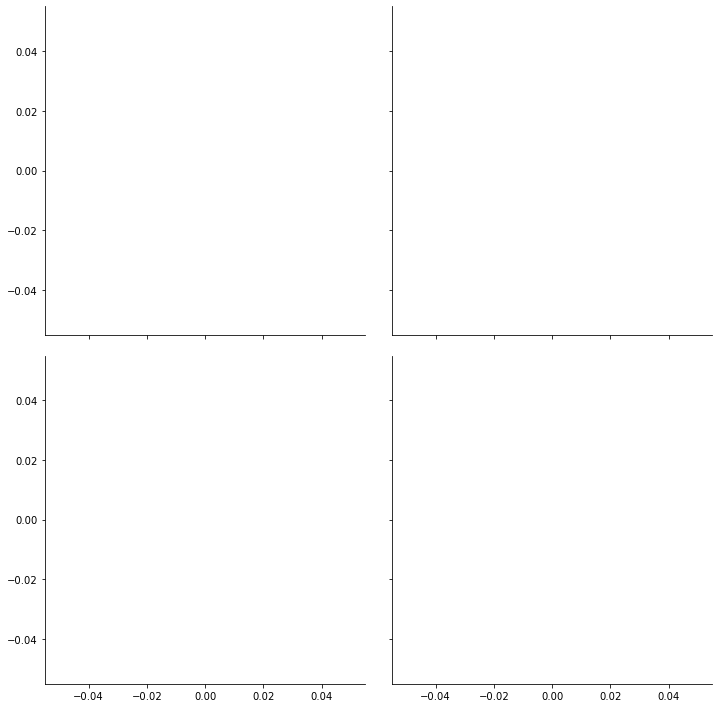

In [21]:
# g = sns.relplot(x="Day", y="QSCORE_DIFF", hue="Condition", units="Patient",
#             row="Condition", col="Location", style="Enrichment",
#             data=labeledOxoQ, kind="line", estimator=None)

<AxesSubplot:ylabel='QSCORE_DIFF'>

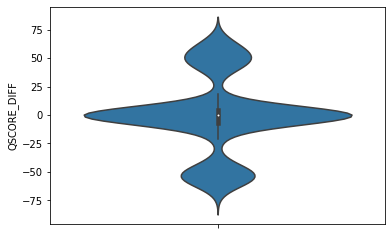

In [11]:
sns.violinplot(y="QSCORE_DIFF", data=labeledOxoQ)

In [12]:
matchedByDay = labeledOxoQ.pivot(index=["REF_BASE","ALT_BASE", "CONTEXT","Patient","Condition"],columns="Day", values="QSCORE_DIFF")

In [25]:
matchedByDay

Day                                                     1   3  Diff by Day
REF_BASE ALT_BASE CONTEXT Patient Condition                               
A        C        AAA     1       Normal               -6  -5            1
                          2       Massive Transfusion  -5  -1            4
                          3       Normal               10 -45          -55
                          4       Massive Transfusion -50  -2           48
                  AAC     1       Normal                0 -51          -51
...                                                    ..  ..          ...
T        G        TTG     4       Massive Transfusion  47   0          -47
                  TTT     1       Normal                0   0            0
                          2       Massive Transfusion   0   0            0
                          3       Normal                0  42           42
                          4       Massive Transfusion  46   0          -46

[768 rows x 3 columns]

In [22]:
matchedByDay['Diff by Day'] = matchedByDay[3] - matchedByDay[1]

<AxesSubplot:ylabel='Diff by Day'>

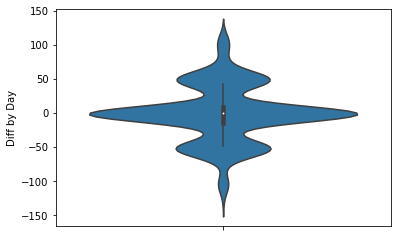

In [26]:
sns.violinplot(y="Diff by Day", data=matchedByDay)

In [29]:
matchedByDay.query('(`Diff by Day` > 75) or (`Diff by Day` < -90)').sort_values("Diff by Day")

Day                                                     1   3  Diff by Day
REF_BASE ALT_BASE CONTEXT Patient Condition                               
C        T        CCG     4       Massive Transfusion  58 -72         -130
G        T        CGG     4       Massive Transfusion  54 -62         -116
C        T        GCC     2       Massive Transfusion  60 -55         -115
G        T        CGC     4       Massive Transfusion  54 -56         -110
C        A        CCG     2       Massive Transfusion  55 -55         -110
                  GCC     4       Massive Transfusion  56 -53         -109
         T        TCA     4       Massive Transfusion  59 -49         -108
                  GCG     2       Massive Transfusion  50 -57         -107
T        C        GTA     2       Massive Transfusion  61 -46         -107
C        G        TCC     4       Massive Transfusion  52 -53         -105
A        T        CAT     4       Massive Transfusion  51 -52         -103
C        A        ACC     4       Massive Transfusion  49 -53         -102
                  TCC     1       Normal               48 -54         -102
A        T        CAG     4       Massive Transfusion  44 -53          -97
C        G        TCT     4       Massive Transfusion  44 -52          -96
T        G        GTC     2       Massive Transfusion  47 -48          -95
C        G        TCC     2       Massive Transfusion  44 -49          -93
G        C        GGA     2       Massive Transfusion -40  40           80
                  AGA     4       Massive Transfusion -48  38           86
A        C        GAA     1       Normal              -50  37           87
G        T        GGA     1       Normal              -44  45           89
A        C        GAC     2       Massive Transfusion -47  42           89
         G        TAC     2       Massive Transfusion -43  46           89
C        G        CCT     1       Normal              -45  45           90
A        G        AAA     2       Massive Transfusion -47  47           94
         C        TAT     4       Massive Transfusion -51  47           98
T        A        ATG     4       Massive Transfusion -47  51           98
C        A        GCG     4       Massive Transfusion -55  47          102
                  CCG     4       Massive Transfusion -60  43          103
T        A        GTT     4       Massive Transfusion -56  47          103
G        C        GGA     4       Massive Transfusion -53  50          103
         T        GGC     4       Massive Transfusion -57  47          104
                  GGT     4       Massive Transfusion -51  53          104
         A        CGC     2       Massive Transfusion -49  57          106
T        A        CTG     4       Massive Transfusion -53  53          106
G        T        CGG     2       Massive Transfusion -56  51          107
         A        GGC     2       Massive Transfusion -53  57          110
                  CGG     4       Massive Transfusion -57  57          114
                  TGA     4       Massive Transfusion -53  62          115
         T        GGT     3       Normal              -60  57          117